Welcome to the in-situ XRD timeline creation! 

# In-situ XRD Timeline

[![Python](https://img.shields.io/badge/Python-3.x-blue.svg)]()
[![Pandas](https://img.shields.io/badge/DataFrame-Pandas-green.svg)]()
[![Plotting](https://img.shields.io/badge/Plots-Matplotlib-orange.svg)]()
[![Fitting](https://img.shields.io/badge/Peaks-Nelson--Riley-red.svg)]()

**Features**
- 📂 Read XRD files & related data (monitor, JV, temperature, light)  
- 📈 Fit XRD peaks with Nelson–Riley regression  
- 🗂 Aggregate results into DataFrames  
- ⏱ Assign timestamps & generate plots  



In [2]:
#Import nessesary libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
pd.set_option('display.max_rows',85)
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
from datetime import datetime, timedelta
import glob
import seaborn as sns
import syre

In [3]:
#IMPORTING CODE FOR BACKGROUND CORRECTIONS FROM ONLINE, SEE REF BELOW. 
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 30 16:05:47 2015

@author: M Wieser

LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
"""


import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as plt


def als(y, lam=1e5, p=0.2, itermax=15):
    """
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z



def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    """
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z



def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)



def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z


In [4]:
#Here we define the mathematical functions for the fittings of XRD peaks

def gaussian(x, c, a, s): 
    return a * np.exp(-(x-c)**2 / (2*s**2))

def lorentzian(x, c, a, g): 
    return a*((g**2)/ ((x-c)**2 + g**2))

def pseudo_voigt(x, c, a, s, g, eta):
    #eta is the mixing parameter, 0 if pure gaussian, 1 if pure lorentzian. Eta has to be between 0 and 1
    return  (1-eta)*gaussian(x, c, a, s) + eta*lorentzian(x, c, a, g)

In [5]:
#Defining fittings through least mean squares for accurate decition of best fit for Pseudo Voight function
from scipy.optimize import least_squares

def residuals(params, x,y):
    return y - pseudo_voigt(x, *params)

def fit_least_squares(x,y,initial_guess, lower_bounds, upper_bounds, plot):
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, label='Original Data', color='blue', alpha=0.7)
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
    param = least_squares(residuals, initial_guess, bounds = (lower_bounds,upper_bounds), args=(x,y))
    c,a,s,g,eta = param.x
    yf = pseudo_voigt(x,c,a,s,g,eta)
    amplitude = max(yf)
    wsum = s+g
    resi = y - yf
    if plot: 
        plt.plot(x, yf, label='Pseudo-Voigt Fit', color='red')
        plt.scatter(x, resi, label='residuals', color='green', alpha=0.7)
        plt.scatter([], [], label='Eta:'+ str(eta) + ' stdv:' + str(s)+ ' fwhm:'+ str(g), color='red', alpha=0.7)
        plt.title('Pseudo-Voigt fitting and residuals')
        plt.legend()
        plt.show()
    return c,amplitude,wsum,eta

In [6]:
#This function fits a peak that had been selected, using the Pseudo-Voigt

def fit_to_peak(x, y, plot, s = 0.05, g = 0.05, e = 0.05): #Fit a Pseudo-Voigt curve to the data and return the parameters.
    center_guess = x[np.argmax(y)]  # Initial guess for the center of the peak is the x-value with maximum y
    initial_guess = [center_guess, max(y), s, g, e]  # Initial guess for amplitude, center, stddevG (sigma), fwhmL(gamma), eta
    lower_bounds = [0, 0, 0.001, 0.001, 0.02]  # eta >= 0
    upper_bounds = [np.inf, np.inf, 1, 1, 0.98]  # eta <= 1
    try:
        c,amp,wsum,eta = fit_least_squares(x, y, initial_guess, lower_bounds, upper_bounds, plot)
    except (RuntimeError, ValueError, TypeError) as e:
        print(f'Pseudo-Voigt fit failed: {e}')
    return c, amp, wsum # Return center, amplitude, stddvG

In [7]:
#Defining functions nessesary for the Nelson Riley regression plot and fitting

import math

def linear(x,a,c):
    return (a*x+c)

def lin_residuals(param, x, y):
    return y - linear(x, *param)

def nelson_riley(df, ax, ax_int, col, parameter_selection, theta_selection, alp, lab):
    perovskite_df = df[df['Peak'].str.startswith('p')]
    low_bound = [0,0]
    high_bound = [1, 6.4]
    initial_guess = [0.001, 6.32]
    for time in perovskite_df['start_time'].unique():
        intercepts = []
        amplitudes = []
        x=[]
        y=[]
        data = perovskite_df[perovskite_df['start_time']==time]
        for peak in data['Peak'].unique():
            peak_df = data[data['Peak']==peak]
            theta = peak_df[theta_selection].iloc[0]/2
            amp = peak_df['amplitude'].iloc[0]
            ax_int.scatter(theta*2, amp, color = col)
            amplitudes.append(amp)
            x.append(math.cos(math.radians(theta))**2 / math.sin(math.radians(theta)) + math.cos(math.radians(theta))**2/math.radians(theta))  
            y.append(peak_df[parameter_selection].iloc[0])
        xn = np.array(x)
        yn = np.array(y)
        ax.scatter(xn, yn, color = col, marker='o', s=40, alpha=alp/2)
        param = least_squares(lin_residuals, initial_guess, bounds=[low_bound, high_bound], args=(xn,yn))
        a, c = param.x
        intercepts.append(c)
        y_fit = linear(xn,a,c)
        ax.plot(xn, y_fit, color = col, label = lab, linewidth = 2, alpha = alp) 
        ax.scatter(0, c, color = col, marker='*', s=120, alpha = alp)
        av_amplitude = np.mean(amplitudes)
    return intercepts, data['sample'].iloc[0], av_amplitude

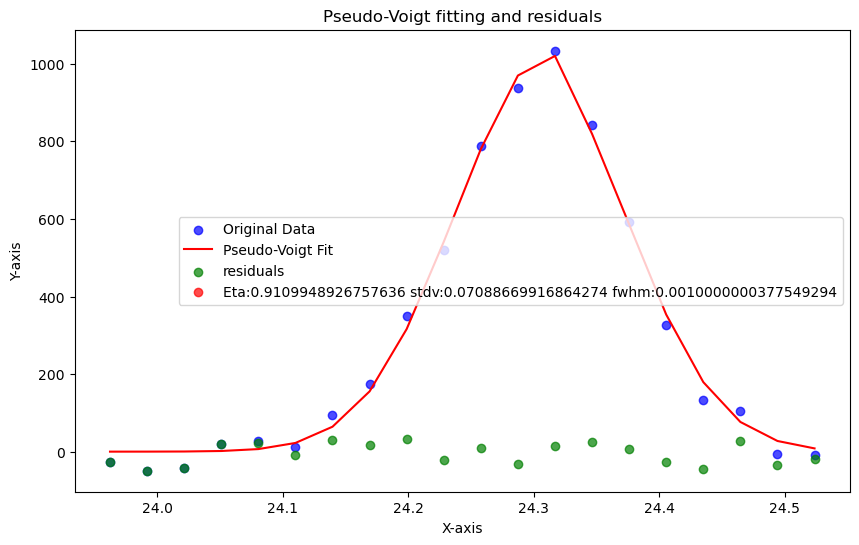

(24.304945099414418, 1020.2231941411027, 0.07188669920639766)

In [8]:
#This is an example data to check the fitting and to give an example of possible output (if one choses to Fitplot)

x = [23.96249, 23.99203, 24.02157, 24.05112, 24.08066, 24.1102,  24.13975, 24.16929,
 24.19883, 24.22838, 24.25792, 24.28746, 24.317,   24.34655, 24.37609, 24.40563,
 24.43518, 24.46472, 24.49426, 24.52381]

y =  [ -27.63293033,  -48.93977031,  -41.24632197,   20.44758829,   28.14217124,
   12.83763557,   95.53418717,  173.23203065,  349.93136106,  520.63235612,
  788.33515857,  937.03985909, 1033.7464695,   843.45490795,  593.1649892,
  325.87644365,  133.58894241,  105.30212399,   -6.98438647,   -9.27097434]

fit_to_peak(x,y, True)

In [9]:
'''
braggs(the2) applies Bragg's law, n*lambda = 2*d*sin(theta) to calculate the interplanar distance (d) from a 2theta value, assuming n=1

reverse_braggs(d) reverts a d_value to the corresponding 2theta value

a_value(d, h, k, l) calculates the lattice parameter a for a CUBIC SYSTEM according to d = a / sin(h^2+k^2+l^2)

'''

import math

def braggs(the2, lam = 1.541874):
    '''Braggs: nλ = 2d sin (theta)  #n = 2 for 002 
    #(n*lam) = 0.5*d / math.sin(theta) #where n is int
    En general para los cálculos utilizamos el valor promedio de Kalpha = 1.541874 Angstroms.
    This value can vary more for much higher reflections where we could have peak splitting 
    The setup used a Parabolic Mirror
    '''
    theta = the2/2
    theta_rad = math.radians(theta)                           
    d = lam / (2*math.sin(theta_rad)) #interplanar distance
    return d
                                      
def reverse_braggs(d, lam = 1.541874):
    theta_rad = math.asin(lam/(2*d))
    theta_deg = math.degrees(theta_rad)
    the2 = 2*theta_deg
    return the2                                      

def a_value(d, h, k, l):
    # d = a / sqrt(h**2 + k**2 + l**2) #a = lam*0.5*math.sqrt((h**2)+(k**2)+(l**2))/math.sin(theta)
    return d*math.sqrt(h**2 + k**2 + l**2)

def a_reverse(a,h,k,l):
    d = a / math.sqrt(h**2 + k**2 + l**2)
    return d

In [10]:
#This function background-corrects and fits the entire x,y array input with certain thresholds

def fit_XRD(ax, x_array, y_array, low_Xthres, high_Xthres, maxpeaks, Fitplot, min_xdelta=0.5, y_thres=100):   
    #plt.plot(x_array,y_array, color='b')  
    #Complet: threshold_y = 100, threshold_value = 8, up_threshold_value = 59, min_xdelta=1, maxpeaks = 15
    #FTO: low_threshold_x = 25.1, up_threshold_x = 27.5, maxpeaks=2
    #partial : maxpeaks = 5, low_threshold_x = 24, up_threshold_x = 33,
    amplitudes = []
    centers = []
    stddevs = []
    peak_count = 0  # Counter to track the number of peaks found
    threshold_y = y_thres  # Threshold for peak identification in y-direction
    min_distance_x = min_xdelta  # Minimum distance between peaks in x-direction
    low_threshold_x = low_Xthres
    up_threshold_x = high_Xthres
    last_peak_x = low_Xthres
    #estimated_background = als(y_array)
    estimated_background = airpls(y_array)
    #plt.plot(x_array,estimated_background, color='r')    #Uncomment to plot the background corrected spectra
    #estimated_background = np.convolve(y_array, np.ones(len(y_array))/(len(y_array)), mode='same') #This was the old background correction
    y_bc_array = y_array-estimated_background
    ax.plot(x_array, y_bc_array, alpha = 0.2)
    indices_beyond_threshold = []
    for i in range(x_array.size): 
        if x_array[i] < up_threshold_x: # Stop BEFORE going beyond scan
            if x_array[i] > low_threshold_x:
                indices_beyond_threshold.append(i)
    for i in indices_beyond_threshold:
        if (y_bc_array[i-3] < y_bc_array[i] > y_bc_array[i+5]) and y_bc_array[i] > threshold_y:
            center, amplitude, wsum = fit_to_peak(x_array[i-10:i+10], y_bc_array[i-10:i+10], Fitplot)
            #print(center,amplitude,wsum)
            if center == None :
                continue
            elif center > low_threshold_x:
                if peak_count == 0: 
                    peak_count += 1
                    amplitudes.append(amplitude)
                    centers.append(center)
                    stddevs.append(wsum)
                    last_peak_x = center
                elif (center-last_peak_x) < min_distance_x: # Check minimum distance between peaks in x-direction
                    if wsum < stddevs[peak_count-1]:      #if amplitude > amplitudes[peak_count-1]:
                        amplitudes[peak_count-1] = amplitude
                        centers[peak_count-1] = center
                        stddevs[peak_count-1] = wsum
                        last_peak_x = center
                    continue
                else: 
                    peak_count += 1
                    if peak_count == maxpeaks+1:  # Stop if finding too many peaks
                        break
                    amplitudes.append(amplitude)
                    centers.append(center)
                    stddevs.append(wsum)
                    last_peak_x = center
    return centers, amplitudes, stddevs, peak_count

In [11]:
#framefit is a function to interate through a dataframe with samples as rows and creating x,y arrays of XRD data to be sent for fitting, then assigning what peak belongs to the data and putting the values with metadata in a dataframe to be returned. 

def framefit(df, low, high, peak_names, peak_ranges, max, ref_ftoAvalue, ythres, pl):
    #colrs = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
    result_df = pd.DataFrame()
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    ax.set_xlim(25,25.6)
    ax.set_ylim(0.0,250.0)
    for time in df['start_time'].unique():
        data = df[df['start_time']==time]
        end = data['end_time'].iloc[0]
        rel_a = data['rel_a'].iloc[0]
        #print(sample['Variation'].iloc[0])
        #a_rel = df_xshift[df_xshift['Sample']==samp]['a_rel'].iloc[0]
        x_array = data['x_array'].iloc[0]
        y_array = data['y_array'].iloc[0]
        x_parray = np.array(x_array)
        y_parray = np.array(y_array)
        centers, amplitudes, stddevs, peak_count = fit_XRD(ax, x_parray, y_parray, low, high, max, y_thres=ythres, Fitplot=pl) 
        #print(center)
        peaks = []
        d_values=[]
        for center in centers: 
            i = 0
            peak = None
            while i < len(peak_names):
                if peak_ranges[i][0] < center < peak_ranges[i][1]:
                    peak = peak_names[i]
                    if peak == 'FTO(110)':
                        rel_a = (a_value(braggs(center), 1, 1, 0))/ref_ftoAvalue
                i+=1
            if peak == None: 
                peak = 'Unknown'
            d = braggs(center)
            d_values.append(d)
            peaks.append(peak)
        new_sample_df = pd.DataFrame({
            'start_time': time, 
            'end_time': end,    
            'light': data['light'].iloc[0],
            'temp': data['temperature'].iloc[0],
            'sample': data['Sample'].iloc[0],
            'Peak': peaks,
            'pos': centers,
            'amplitude': amplitudes,
            'stdvG': stddevs, 
            'd_value': d_values,
            'rel_a': rel_a
        })
        result_df = pd.concat([result_df, new_sample_df])
    return result_df


In [12]:
#This code if to read xrdml files into a dataframe
def readXRDML(path):
    with open(path, 'r') as file:
        i=0
        for _ in range(115):  # adjust this number based on how deep the header is
            line = file.readline()
            if '<startPosition>' in line:
                if i == 0:
                    theta_min = float(line.split('<startPosition>')[1].split('</startPosition>')[0])
                else:
                    omega_min = float(line.split('<startPosition>')[1].split('</startPosition>')[0])
            if '<endPosition>' in line:
                if i == 0:
                    theta_max = float(line.split('<endPosition>')[1].split('</endPosition>')[0])
                    i+=1
                else:
                    omega_max = float(line.split('<endPosition>')[1].split('</endPosition>')[0])
            if '<startTimeStamp>' in line:
                start_time = line.split('<startTimeStamp>')[1].split('</startTimeStamp>')[0]
            if '<endTimeStamp>' in line:
                end_time = line.split('<endTimeStamp>')[1].split('</endTimeStamp>')[0]
            if '<counts' in line:
                y_array_string = line.split('<counts unit="counts">')[1].split('</counts>')[0]            
    file.close()
                 
    #print(start_time)  
    #print(end_time)
    #print(theta_min)
    #print(omega_min)
    #print(theta_max)
    #print(omega_max)
    y_array = [float(y) for y in y_array_string.split(' ')]
    y = np.array(y_array)
    two_theta = np.linspace(theta_min,theta_max,len(y))  
    return two_theta, y, start_time, end_time

#In the case of starting from Excel files, see read commando below in the main script
#Call it like this: 
#x_2theta, y_counts, start_time, end_time = readXRDML(path)

In [13]:
#Here we ensure syre is correctly imported before reading in all the raw data, REMEMBER TO KEEP SYRE RUNNING IN ORDER FOR THE PROGRAM NOT TO CRASH.
#IF THE PROGRAM CRASHES YOU WILL OBTAIN A "RESOURCE UNAVAILABLE" ERROR
import syre 


In [14]:
# XRDframe fits ONE syre database asset to the format of the Dataframe and returns a one-line DataFrame

def XRDframe(ax, ass, light, temp):
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    two_theta, y, start_time, end_time = readXRDML(file)
    start = pd.to_datetime(start_time)
    end = pd.to_datetime(end_time)
    center, amplitude, stddev, peak_count = fit_XRD(ax, two_theta, y, low_Xthres=25.8, high_Xthres=27.5, maxpeaks=5, y_thres=200, Fitplot=False)
    d = braggs(center[0])
    a = (a_value(d, 1, 1, 0))
    new_input = pd.DataFrame({
        'File':file,
        'start_time': start,
        'end_time':end,
        'FTO110_pos': center[0], 
        'Sample': samp,
        'Variation': var,
        'light':light,
        'temperature':temp, 
        'd_value_fto110': d,
        'a_value_fto110':a, 
        'x_array': [two_theta], 
        'y_array':[y]
    })
    return new_input

\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\22_BMKP2_DP16P2_FTO_2Tw_SM_dark_cooling.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\23_BMKP2_DP16P2_FTO_2Tw_SM_L_cooling.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\24_BMKP2_DP16P2_FTO_2Tw_SM_dark_cooling.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\25_BMKP2_DP16P2_FTO_2Tw_SM_L_RT_cooling.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\26_BMKP2_DP16P2_FTO_2Tw_SM_dark_RT_cooling.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\27_BMKP2_DP16P2_FTO_2Tw_SM_dark_set39.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\28_BMKP2_DP16P2_FTO_2Tw_SM_dark_RT.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\01_BMKP2_DP16P2_FTO_2Tw_SM_dark_RT.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\data\MOD\DP16P2\02_BMKP2_DP16P2_FTO_2Tw_SM_L_RT.xrdml
\\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\da

Text(0, 0.5, 'Intensity')

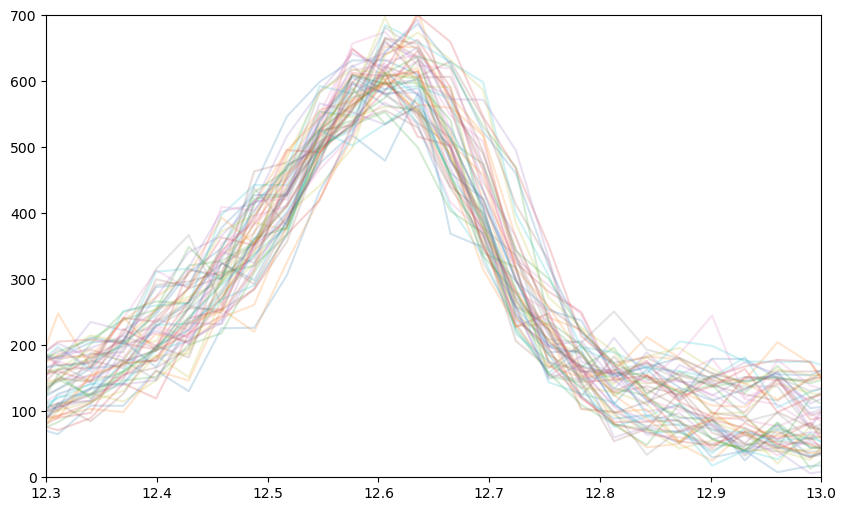

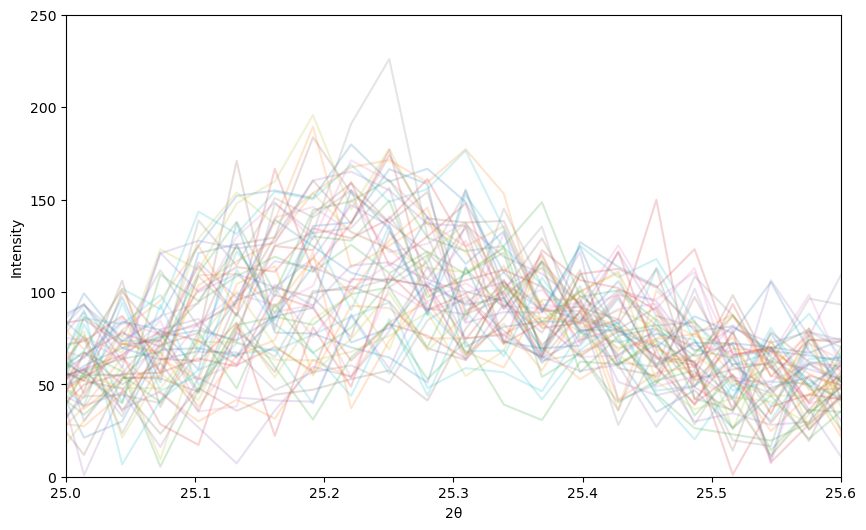

In [ ]:
#HERE STARTS THE MAIN CODE!
# - Read in data from the database sorted accordingly to use main samples
# - Iterate through all asssets, fit data and add the results of fitting in a DataFrame, including calculating the a-values and correcting them with the FTO 110 peak
# - Important to select the correct path to the data-folder of the Syre folder structure, and to add the correct intervals, peak names, peak ranges. adjust inverval for fitting by low and high
# THIS PROGRAM TAKES BETWEEN 1 MINUTE AND 10 MINUTES TO EXEC DEPENDING ON THE AMOUNT OF DATA

df_input = pd.DataFrame()
db = syre.Database(dev_root=r'C:\\Users\\fbaumann\\PyProjects_AMZ\\Project2\\data')
assets = db.find_assets()
main_assets = list(filter(lambda asset: asset.metadata["sample"]=='main', assets))
xrd_assets = list(filter(lambda asset: asset.file.endswith("xrdml"), main_assets))
#xrd_01_assets = list(filter(lambda asset: '01' in asset.file, xrd_assets))
#xrd_02_assets = list(filter(lambda asset: '02' in asset.file, xrd_assets))
#xrd_03_assets = list(filter(lambda asset: '03' in asset.file, xrd_assets))

'''for ass in xrd_01_assets:
    new_frame = XRDframe(ass, light='dark', temp='RT')
    df_input = pd.concat([df_input, new_frame])
for ass in xrd_02_assets:
    new_frame = XRDframe(ass, light='1_sun', temp='RT')
    df_input = pd.concat([df_input, new_frame])'''
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
ax.set_xlim(12.3,13), ax.set_ylim(0, 700)
for ass in xrd_assets:
    print(ass.file)
    lig = ass.file[-16:-10]
    tp = ass.file[-13:-5]
    new_frame = XRDframe(ax, ass, light=lig, temp=tp)
    df_input = pd.concat([df_input, new_frame])

ref_ftoAvalue = df_input['a_value_fto110'].mean()
rel_a = []
a_corr = []
i = 0
while i < df_input.index.size:
    a = df_input['a_value_fto110'].iloc[i]
    a_rel = a/ref_ftoAvalue
    rel_a.append(a_rel)
    corr_a = a / a_rel
    a_corr.append(corr_a)
    i+=1
df_input.insert(3, 'rel_a', rel_a)
df_input.insert(4, 'corr_a', a_corr)
#print(df_input['x_array'].iloc[3])

peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12.9], [13.8,14.5], [19,20], [21,23], [24,25], [26,27],[27.7,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43.1], [43.1,45], [48,50.5], [50.5,52], [52,55],[55,60]]
low = 10
high = 44
result_df = framefit(df_input, low, high, peak_names, peak_ranges, 19, ref_ftoAvalue, 200, pl=False)
a_values_raw = []
a_aligned = []
i = 0
while i < result_df.index.size: 
    d = result_df['d_value'].iloc[i]
    peak = result_df['Peak'].iloc[i]
    rel_a  = result_df['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        print(peak, result_df['pos'].iloc[i])
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_df['a_raw'] = a_values_raw
result_df['a_final'] = a_aligned

print(result_df)
plt.xlabel('2θ')
plt.ylabel('Intensity')

                 start_time                  end_time   light      temp  \
0 2025-01-27 17:11:55+01:00 2025-01-27 17:58:36+01:00  SM_dar  dark_RT.   
0 2025-01-27 17:58:53+01:00 2025-01-27 18:45:32+01:00  Tw_SM_  SM_L_RT.   
0 2025-01-27 18:45:49+01:00 2025-01-27 19:32:27+01:00  Tw_SM_  SM_L_85.   
0 2025-01-27 19:32:44+01:00 2025-01-27 20:19:23+01:00  SM_dar  dark_85.   
0 2025-01-27 20:19:40+01:00 2025-01-27 21:06:19+01:00  Tw_SM_  SM_L_85.   
0 2025-01-27 21:06:35+01:00 2025-01-27 21:53:14+01:00  SM_dar  dark_85.   
0 2025-01-27 21:53:31+01:00 2025-01-27 22:40:10+01:00  Tw_SM_  SM_L_85.   
0 2025-01-27 22:40:27+01:00 2025-01-27 23:27:06+01:00  Tw_SM_  SM_L_85.   
0 2025-01-27 23:27:23+01:00 2025-01-28 00:14:02+01:00  Tw_SM_  SM_L_85.   
0 2025-01-28 00:14:18+01:00 2025-01-28 01:00:57+01:00  Tw_SM_  SM_L_85.   
0 2025-01-28 01:01:14+01:00 2025-01-28 01:47:53+01:00  Tw_SM_  SM_L_85.   
0 2025-01-28 01:48:10+01:00 2025-01-28 02:34:49+01:00  Tw_SM_  SM_L_85.   
0 2025-01-28 02:35:06+01:

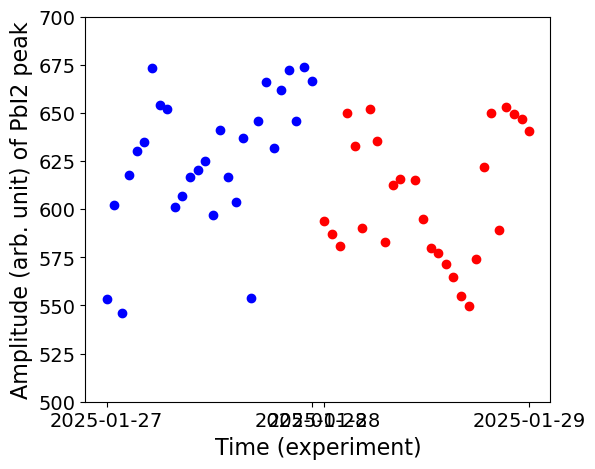

In [16]:
#Checking the change in the PbI2 peak over time
#THE CODE IS SAMPLE SPECIFIC, MAKE SURE SAMPLE NAMES COINCIDE and that the timeframe for plotting makes sence (In this case the samples were mesured after each other - works fine)

sorted_result_df = result_df.sort_values(by=['start_time'])
print(sorted_result_df[sorted_result_df['Peak']=='i2Pb'])
sort_PbI2 = sorted_result_df[sorted_result_df['Peak']=='i2Pb']
colors = {'3P1long': 'blue', '16P2long': 'red'}
#colors = {'18P1onOFF': 'red', '7P1onOFF': 'blue'}
fig = plt.figure(figsize=(6,5))
ax = fig.gca()
for samp in sort_PbI2['sample'].unique():
    ax.scatter(sort_PbI2[sort_PbI2['sample']==samp]['start_time'], sort_PbI2[sort_PbI2['sample']==samp]['amplitude'], color=colors[samp])
ax.set_ylim(500, 700)
ax.set_xlabel('Time (experiment)', fontsize=16)
ax.set_ylabel('Amplitude (arb. unit) of PbI2 peak', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([sort_PbI2[sort_PbI2['sample']=='3P1long']['start_time'].min(), sort_PbI2[sort_PbI2['sample']=='3P1long']['start_time'].max(), sort_PbI2[sort_PbI2['sample']=='16P2long']['start_time'].min(), sort_PbI2[sort_PbI2['sample']=='16P2long']['start_time'].max()])

In [ ]:
#Unmark to print the entire DataFrame
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(result_df)

<>:48: SyntaxWarning: invalid escape sequence '\T'
<>:48: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\2911684471.py:48: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


     Sample      Temp                Time  intercept  av_amplitude
0  16P2long  cooling. 2025-01-29 07:40:26   6.301765    755.418890
0  16P2long  cooling. 2025-01-29 09:14:16   6.282123    730.857050
0  16P2long  cooling. 2025-01-29 10:01:12   6.276684    745.241636
0  16P2long  cooling. 2025-01-29 10:48:08   6.283536    732.927823
0  16P2long  cooling. 2025-01-29 11:35:04   6.275458    733.029564
0  16P2long  k_set39. 2025-01-29 12:22:00   6.278994    733.036523
0  16P2long  dark_RT. 2025-01-29 13:08:54   6.275048    733.816480
0  16P2long  dark_RT. 2025-01-28 16:01:50   6.284950    718.272276
0  16P2long  SM_L_RT. 2025-01-28 16:48:46   6.290984    715.500718
0  16P2long  SM_L_85. 2025-01-28 17:35:42   6.309749    724.456271
0  16P2long  dark_85. 2025-01-28 18:22:38   6.304139    757.069001
0  16P2long  SM_L_85. 2025-01-28 19:09:34   6.307102    714.615631
0  16P2long  dark_85. 2025-01-28 19:56:30   6.299739    725.863326
0  16P2long  SM_L_85. 2025-01-28 20:43:26   6.305746    786.23

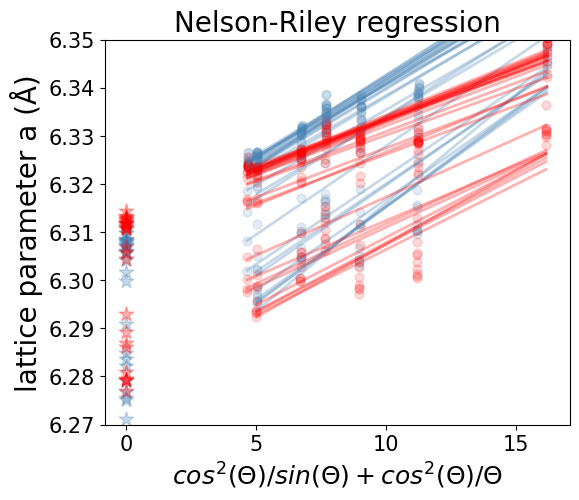

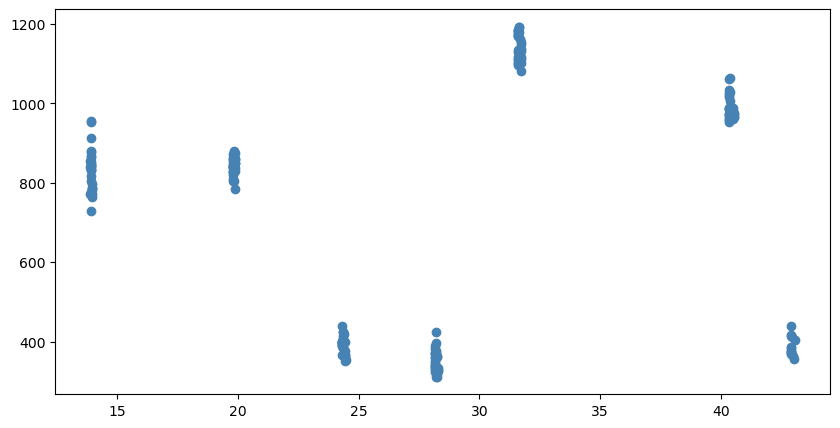

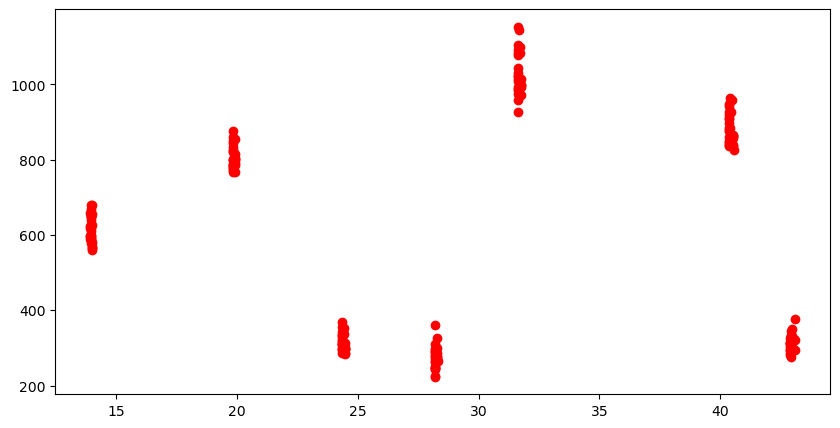

In [17]:
#Nelson-Riley figure, there are several options here, currently left as the included figures in manuscripts

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red','green', 'darkorange', 'navy','green','orange','black','grey', 'indigo']
col_ind = 0
nr = pd.DataFrame()
for device in result_df['sample'].unique():  
    fig_int = plt.figure(figsize=(10,5))
    ax_int = fig_int.gca() 
    temps_array = []
    temp_count = 0
    data = result_df[result_df['sample']==device]
    '''if device == '16P2':
        col_ind = 1
    else: 
        col_ind = 0'''
    for time in data['start_time'].unique():
        dat = data[data['start_time']==time]
        temp = dat['temp'].iloc[0]
        mid_time = datetime.fromtimestamp(np.round(dat['start_time'].iloc[0].timestamp() + (dat['end_time'].iloc[0].timestamp() - dat['start_time'].iloc[0].timestamp())/2))        
        '''if temp in temps_array: 
            if temp_count > len(temps_array):
                continue
            alf = 0.5
            temp_count += 1
        else: 
            col_ind+=1
            temps_array.append(temp)
            if 'L' in dat['temp'].iloc[0]:
                alf = 0.9
            else: 
                alf = 0.6 - len(temps_array)*0.08'''
        c, samp, av_amp = nelson_riley(dat, ax, ax_int, col_array[col_ind], 'a_raw', 'pos', alp=0.3, lab=dat['sample'].iloc[0]+'-'+dat['light'].iloc[0]+str(dat['temp'].iloc[0]))
        nr_new = pd.DataFrame({
            'Sample':samp, 
            'Temp':temp, 
            'Time':pd.to_datetime(mid_time), 
            'intercept':c, 
            'av_amplitude':av_amp
            })
        nr = pd.concat([nr, nr_new])
    col_ind += 1

ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
ax.set_ylim(6.27,6.35)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
#ax.legend(loc='upper left', fontsize=5)  
print(nr)


     Sample      Temp                Time  intercept  av_amplitude
0  16P2long  dark_RT. 2025-01-28 16:01:50   6.284950    718.272276
0  16P2long  SM_L_RT. 2025-01-28 16:48:46   6.290984    715.500718
0  16P2long  SM_L_85. 2025-01-28 17:35:42   6.309749    724.456271
0  16P2long  dark_85. 2025-01-28 18:22:38   6.304139    757.069001
0  16P2long  SM_L_85. 2025-01-28 19:09:34   6.307102    714.615631
0  16P2long  dark_85. 2025-01-28 19:56:30   6.299739    725.863326
0  16P2long  SM_L_85. 2025-01-28 20:43:26   6.305746    786.237955
0  16P2long  SM_L_85. 2025-01-28 21:30:21   6.307685    718.417434
0  16P2long  SM_L_85. 2025-01-28 22:17:16   6.311107    702.126258
0  16P2long  SM_L_85. 2025-01-28 23:04:12   6.307929    736.694728
0  16P2long  SM_L_85. 2025-01-28 23:51:08   6.308135    709.701059
0  16P2long  SM_L_85. 2025-01-29 00:38:04   6.308251    777.364045
0  16P2long  SM_L_85. 2025-01-29 01:25:00   6.309848    712.205291
0  16P2long  SM_L_85. 2025-01-29 02:11:56   6.308210    715.53

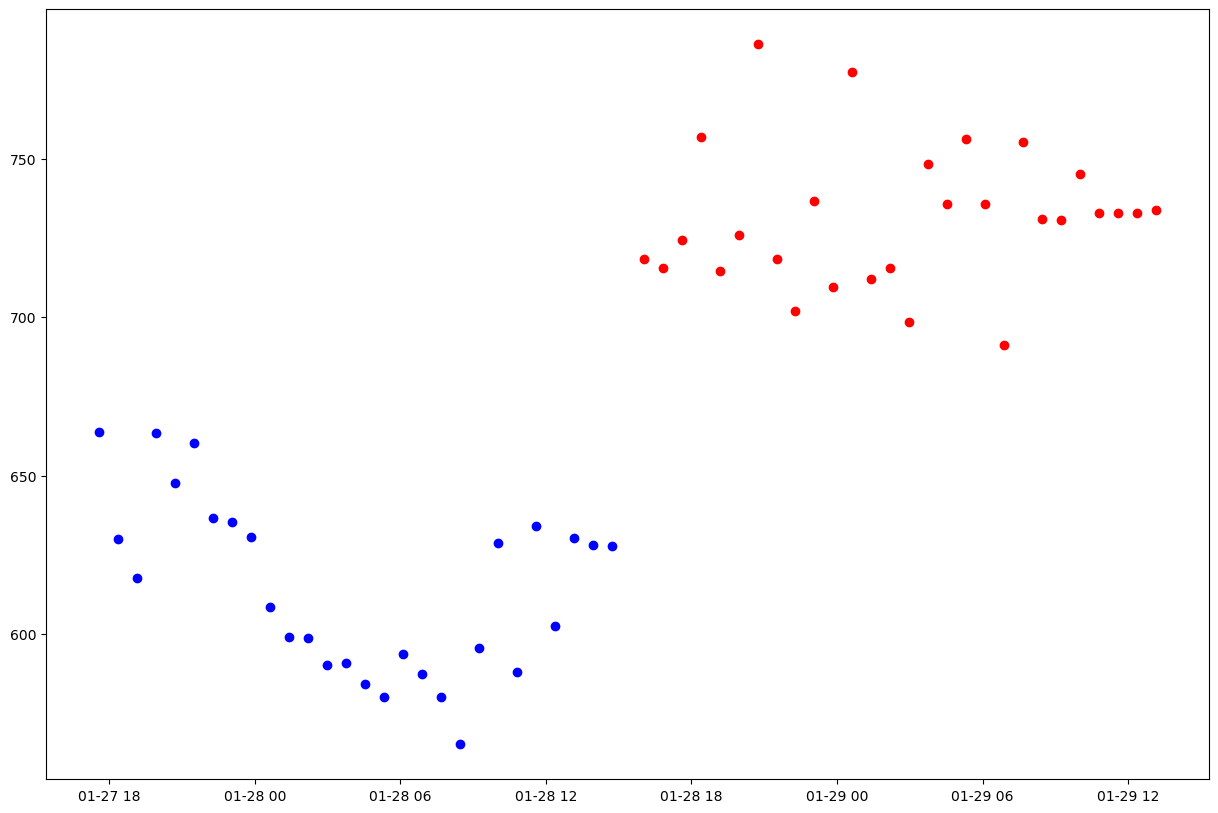

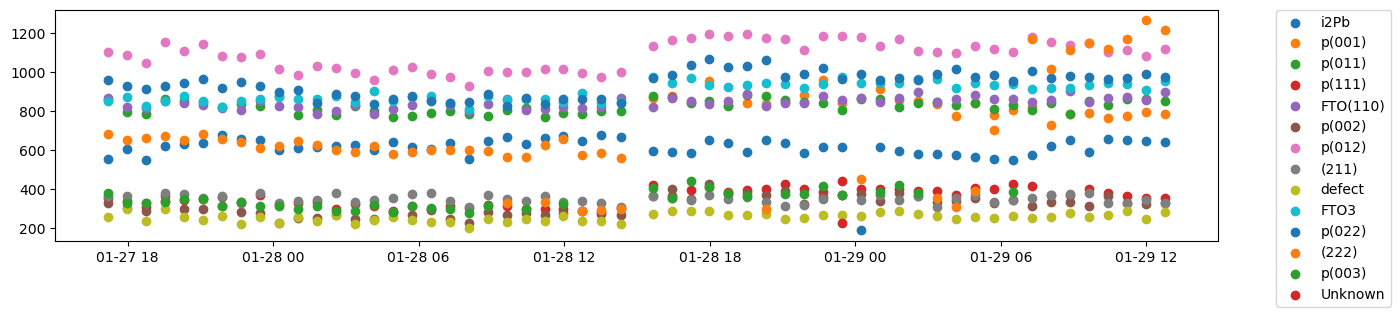

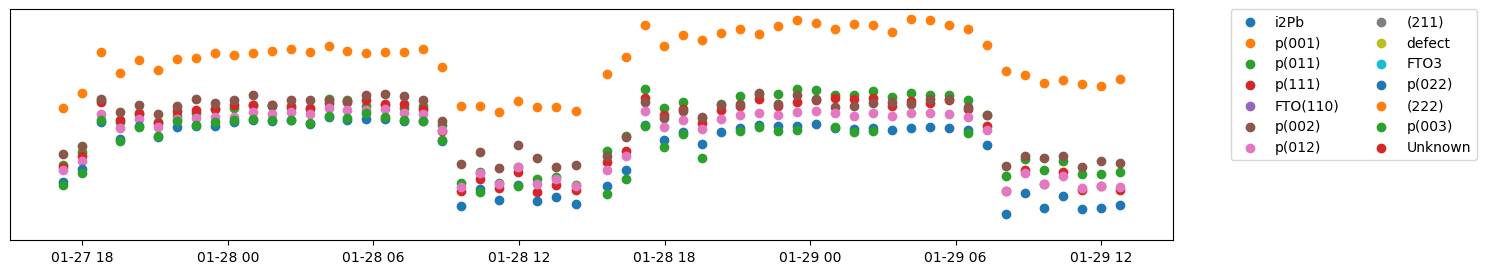

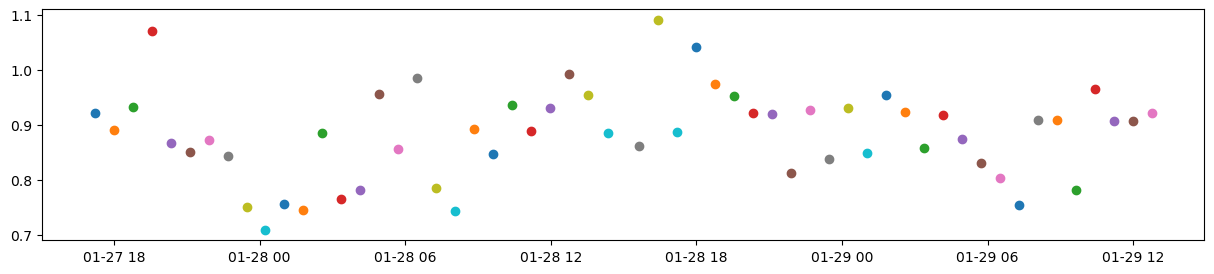

In [18]:
#PLotting of average data for all peaks (a-value from NR) or individua

#Joining NR df to a list
nr = nr.sort_values(by=['Time'], ascending=True)
mod_nr = nr[nr['Sample'].str.startswith('16')]
ref_nr = nr[nr['Sample'].str.startswith('3')]
print(mod_nr)
print(ref_nr)
nr_list = [mod_nr, ref_nr]

#Plot average amplitude (all peaks) changes over time
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
plt.scatter(mod_nr['Time'], mod_nr['av_amplitude'], color='red', label='MOD')
plt.scatter(ref_nr['Time'], ref_nr['av_amplitude'], color='blue', label='REF')

#Plot all peaks amplitude over time
fig2 = plt.figure(figsize=(15,3))
ax2 = fig2.gca()
for peak in result_df['Peak'].unique():
    ax2.scatter(result_df[result_df['Peak'] == peak]['start_time'], result_df[result_df['Peak'] == peak]['amplitude'], label = peak)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#Plot all peaks a-value over time
fig3 = plt.figure(figsize=(15,3))
ax3 = fig3.gca()
for peak in result_df['Peak'].unique():
    ax3.scatter(result_df[result_df['Peak'] == peak]['start_time'], result_df[result_df['Peak'] == peak]['a_final'], label = peak)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncols=2)
ax3.set_ylim(6.28,6.37)

#Plot comparison with (002) and (111),can also compare other peaks, to check microstructure changes (changes in preferential orientation)
fig4 = plt.figure(figsize=(15,3))
ax4 = fig4.gca()
p002 = result_df[result_df['Peak'] == 'p(002)']
p111 = result_df[result_df['Peak'] == 'p(111)']
for time in p002['start_time'].unique():
    ax4.scatter(time, p002[p002['start_time']==time]['amplitude'].iloc[0]/p111[p111['start_time']==time]['amplitude'].iloc[0])
#ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#ax4.set_ylim(1.979,1.98)

In [19]:
#Import monitoring files from a list of syre assets, returns all monitoring files as one DataFrame
def monitoring_files(asset_list):
    # Initialize empty lists to store data
    all_data = []
    
    for asset in asset_list:
        file = asset.file
        # Read the file with tab delimiter and specified column names
        df = pd.read_csv(file, delimiter='\t', skiprows=1,
                        names=['Counter', 'Date', 'RealTime', 'TimeDouble', 
                              'Voltage', 'Corriente', 'Resistance'])
        # Convert date and time to datetime
        df['Time'] = pd.to_datetime(df['Date'] + ' ' + df['RealTime'], 
                                      format='%m-%d-%Y %H:%M:%S')
        
        # Store in list
        all_data.append(df)
    
    # Concatenate all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Sort by datetime
    combined_df = combined_df.sort_values('Time')
    #print(combined_df['Time'])
    
    # Calculate relative time in hours from first measurement
    start_time1 = combined_df['Time'].min()
    combined_df['Time_hours'] = (combined_df['Time'] - start_time1).dt.total_seconds() / 3600
    combined_df['Power-PCE'] = combined_df['Voltage']*combined_df['Corriente']*-1000/0.16    #"PCE" = V (V) * Curr (mA) / area (cm2)
    
    return combined_df

In [20]:
#Reading and formatting data into DataFrame from IV
def read_iV(file, start_tim, end_tim):
    #print(file)
    iv_data = pd.read_csv(file, delimiter='\t', header=None, encoding='latin1')
    # Extract timestamp from middle of file
    date_part = start_tim.strftime('%Y-%m-%d')
    time_hm = iv_data[0].iloc[len(iv_data)//2]
    #print(f"time value: {time_hms}")
    if int(str(time_hm).split(':')[0]) > 23:
        # Add one day to date_part
        date_part = (pd.to_datetime(date_part) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        #print(date_part)
        # Adjust hour value
        hourss = int(str(time_hm).split(':')[0]) - 24
        time_hm = f"{hourss:02d}:{':'.join(str(time_hm).split(':')[1:])}"

    mid_tim = pd.to_datetime(f'{date_part} {time_hm}', format='%Y-%m-%d %H:%M:%S')

    #print(mid_time.hour)
    #plt.plot(iv_data[1], iv_data[2])
    if start_tim <= mid_tim <= end_tim:
        #print(mid_tim)

         # Find index of maximum voltage
        max_v_idx = np.argmax(iv_data[1])
        # Split voltage and current data at max voltage
        v_forward = np.array(iv_data[1][:max_v_idx+1])
        i_forward = np.array(iv_data[2][:max_v_idx+1])
        v_reverse = np.array(iv_data[1][max_v_idx:])
        i_reverse = np.array(iv_data[2][max_v_idx:])

        return mid_tim, v_forward, i_forward, v_reverse, i_reverse
    else: 
        return None, None, None, None, None

In [21]:
#Taking and relating the NR data to iv-data and forming a big df with the data
def iv_frame(nR, light_iv_assets, dark_iv_assets, plot):
    iv_matches = pd.DataFrame(columns=['NR_time', 'state', 'jv_time', 'type', 'voltage', 'current'])
    color_dict = {
        'OFF-LOW': 'steelblue',
        'ON-HIGH': 'darkorange',
        'OFF-HIGH': 'darkorange',
        'ON-LOW': 'steelblue'
    }
    if plot:
        fig_light  = plt.figure(figsize=(6, 5))
        ax_light = fig_light.gca()
        ax_light.set_xlabel('Voltage (V)', fontsize=20)
        ax_light.set_ylabel('Current Density (mA/cm2)', fontsize=20)
        ax_light.tick_params(axis='both', which='major', labelsize=16)
        ax_light.legend(loc = 'lower left', fontsize=16)
        ax_light.set_title('Light JV Curves', fontsize=20)
        ax_light.set_xlim([-0.1,1.21])
        ax_light.set_ylim([2,-25]) 
        # Add to light JV plot
        ax_light.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax_light.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        ax_light.plot([], [], 'k--', label='fw')

        fig_dark  = plt.figure(figsize=(6, 5))
        ax_dark = fig_dark.gca()
        ax_dark.set_xlabel('Voltage (V)', fontsize=20)
        ax_dark.set_ylabel('Current (A)', fontsize=20)
        ax_dark.set_xlim([-0.01,1.11])
        ax_dark.set_ylim([-0.00001, 0.004])
        ax_dark.tick_params(axis='both', which='major', labelsize=16)
        ax_dark.legend(fontsize=16)
        ax_dark.set_title('Dark JV Curves', fontsize=20)

        legend_counter = []
        legend_counter2 = []

    time_window_start = pd.Timedelta(minutes=25)  # Adjust window as needed
    time_window_end = pd.Timedelta(minutes=22.5)  # Adjust window as needed

    
    states = []
    max_plots = 3

    for tim in nR['Time'].unique():
        row = nR[nR['Time'] == tim]
        date_part = row['Time'].iloc[0].strftime('%Y-%m-%d')
        time_hm = row['Time'].iloc[0].strftime('%H:%M:%S')
        time_full = f"{date_part} {time_hm}"
        start_tim = pd.to_datetime(time_full) - time_window_start
        end_tim = pd.to_datetime(time_full) + time_window_end
        state = str(f"{row['light_state'].iloc[0]}-{row['Heat_state'].iloc[0]}")
    
        # Check light JV files
        for asset in light_iv_assets:
            t, volt_f, curr_f, volt, curr = read_iV(asset.file, start_tim, end_tim)
            if t:
                states.append(state)
                states_count = sum(1 for s in states if s == state)
                if plot:
                    if states_count <= max_plots:
                        if state not in legend_counter:
                            ax_light.plot(volt, curr/0.00016, color = color_dict[state], label=state)
                            legend_counter.append(state)
                        else: 
                            ax_light.plot(volt, curr/0.00016, color = color_dict[state])
                        ax_light.plot(volt_f, curr_f/0.00016, '--', color = color_dict[state])
                volt = volt[:-1]
                curr = curr[:-1]
                power = volt.astype(float)*curr.astype(float)*-1000
                pce = power.max()/0.16
                new_frame = pd.DataFrame({
                    'NR_time': row['Time'].iloc[0],
                    'state': state,
                    'jv_time': t,
                    'type': 'light',
                    'voltage': [volt],
                    'current': [curr], 
                    'v_fw': [volt_f],
                    'c_fw': [curr_f], 
                    'pce': pce
                })
                if iv_matches.empty:
                    iv_matches = new_frame
                else: 
                    iv_matches = pd.concat([iv_matches, new_frame])
    
        # Check dark JV files
        for asset in dark_iv_assets:
            t, volt, curr, volt_r, curr_r = read_iV(asset.file, start_tim, end_tim)   #Being a bit lazy with this now but only fw for dark and rv for light are stored
            if t:
                states.append(state)
                states_count = sum(1 for s in states if s == state)
                if plot:
                    if states_count <= max_plots:          
                        if state not in legend_counter2:
                            ax_dark.plot(volt, curr, color = color_dict[state], label=state)
                            legend_counter2.append(state)
                        else:
                            ax_dark.plot(volt, curr, color = color_dict[state])
                        ax_dark.plot(volt_r, curr_r, '--', color = color_dict[state])
                new_frame = pd.DataFrame({
                    'NR_time': row['Time'].iloc[0],
                    'state': state,
                    'jv_time': t,
                    'type': 'dark',
                    'voltage': [volt],
                    'current': [curr], 
                    'v_rv': [volt_r],
                    'c_rv': [curr_r]
                })
                if iv_matches.empty: 
                    iv_matches = new_frame
                else: 
                    iv_matches = pd.concat([iv_matches, new_frame])
    if plot:     
        ax_dark.legend(loc = 'upper left')
        ax_light.legend(loc = 'lower left')

    return iv_matches

In [22]:
#Checking that the NR data is fine
for nR in nr_list:
    print(nR) 

print(nr)

     Sample      Temp                Time  intercept  av_amplitude
0  16P2long  dark_RT. 2025-01-28 16:01:50   6.284950    718.272276
0  16P2long  SM_L_RT. 2025-01-28 16:48:46   6.290984    715.500718
0  16P2long  SM_L_85. 2025-01-28 17:35:42   6.309749    724.456271
0  16P2long  dark_85. 2025-01-28 18:22:38   6.304139    757.069001
0  16P2long  SM_L_85. 2025-01-28 19:09:34   6.307102    714.615631
0  16P2long  dark_85. 2025-01-28 19:56:30   6.299739    725.863326
0  16P2long  SM_L_85. 2025-01-28 20:43:26   6.305746    786.237955
0  16P2long  SM_L_85. 2025-01-28 21:30:21   6.307685    718.417434
0  16P2long  SM_L_85. 2025-01-28 22:17:16   6.311107    702.126258
0  16P2long  SM_L_85. 2025-01-28 23:04:12   6.307929    736.694728
0  16P2long  SM_L_85. 2025-01-28 23:51:08   6.308135    709.701059
0  16P2long  SM_L_85. 2025-01-29 00:38:04   6.308251    777.364045
0  16P2long  SM_L_85. 2025-01-29 01:25:00   6.309848    712.205291
0  16P2long  SM_L_85. 2025-01-29 02:11:56   6.308210    715.53

In [25]:
#Reading in all the light and temperature data and adjusting the time-stamps of each datapoint accordingly

mod_assets = list(filter(lambda asset: asset.metadata['name'].startswith("16"), main_assets))
mod_light1_asset = list(filter(lambda asset: asset.file.endswith("light.txt"), mod_assets))[0]
mod_light2_asset = list(filter(lambda asset: asset.file.endswith("light20.txt"), mod_assets))[0]
mod_temp1_asset = list(filter(lambda asset: asset.file.endswith("temp.txt"), mod_assets))[0]
mod_temp2_asset = list(filter(lambda asset: asset.file.endswith("temp20.txt"), mod_assets))[0]
mod_temp1_df = pd.read_csv(mod_temp1_asset.file, delimiter="\t")
mod_temp2_df = pd.read_csv(mod_temp2_asset.file, delimiter="\t")
mod_temp_df = pd.concat([mod_temp1_df, mod_temp2_df], axis = 0, ignore_index=True)
mod_light1_df = pd.read_csv(mod_light1_asset.file, delimiter="\t")
mod_light2_df = pd.read_csv(mod_light2_asset.file, delimiter="\t")
mod_light_df = pd.concat([mod_light1_df, mod_light2_df], axis = 0, ignore_index=True)

mod_temp_df = pd.concat([pd.to_datetime(mod_temp_df['Date'] + ' ' + mod_temp_df['RealTime']).rename('Time'), mod_temp_df], axis = 1)
mod_light_df = pd.concat([pd.to_datetime(mod_light_df['Date'] + ' ' + mod_light_df['RealTime']).rename('Time'), mod_light_df], axis = 1)

mod_light_df['Light'] = np.where(mod_light_df['Corriente'] > 200e-3, 'ON', 'OFF')
mod_temp_df['Heat_state'] = np.where(mod_temp_df['set_TEMP'] > 0, 'HIGH', 'LOW')
# Calculate seconds since start for all dataframes
mod_start_time = mod_temp_df['Time'].min()
# Convert to seconds since start
mod_temp_df['seconds'] = (mod_temp_df['Time'] - mod_start_time).dt.total_seconds()
mod_nr['seconds'] = (mod_nr['Time'] - mod_start_time).dt.total_seconds()
mod_light_df['seconds'] = (mod_light_df['Time'] - mod_start_time).dt.total_seconds()


ref_assets = list(filter(lambda asset: asset.metadata['name'].startswith("3"), main_assets))

ref_light1_asset = list(filter(lambda asset: asset.file.endswith("light.txt"), ref_assets))[0]
#light2_asset = list(filter(lambda asset: asset.file.endswith("light20.txt"), main_assets))[0]
ref_temp1_asset = list(filter(lambda asset: asset.file.endswith("temp.txt"), ref_assets))[0]
#temp2_asset = list(filter(lambda asset: asset.file.endswith("temp20.txt"), main_assets))[0]
ref_temp_df = pd.read_csv(ref_temp1_asset.file, delimiter="\t")
#temp2_df = pd.read_csv(temp2_asset.file, delimiter="\t")
#temp_df = pd.concat([ref_temp1_df, ref_temp2_df], axis = 0, ignore_index=True)
ref_light_df = pd.read_csv(ref_light1_asset.file, delimiter="\t")
#light2_df = pd.read_csv(light2_asset.file, delimiter="\t")
#light_df = pd.concat([ref_light1_df, ref_light2_df], axis = 0, ignore_index=True)

ref_temp_df = pd.concat([pd.to_datetime(ref_temp_df['Date'] + ' ' + ref_temp_df['RealTime']).rename('Time'), ref_temp_df], axis = 1)
ref_light_df = pd.concat([pd.to_datetime(ref_light_df['Date'] + ' ' + ref_light_df['RealTime']).rename('Time'), ref_light_df], axis = 1)

ref_light_df['Light'] = np.where(ref_light_df['Corriente'] > 200e-3, 'ON', 'OFF')
ref_temp_df['Heat_state'] = np.where(ref_temp_df['set_TEMP'] > 0, 'HIGH', 'LOW')
# Calculate seconds since start for all dataframes
ref_start_time = ref_temp_df['Time'].min()
# Convert to seconds since start
ref_temp_df['seconds'] = (ref_temp_df['Time'] - ref_start_time).dt.total_seconds()
ref_nr['seconds'] = (ref_nr['Time'] - ref_start_time).dt.total_seconds()
ref_light_df['seconds'] = (ref_light_df['Time'] - ref_start_time).dt.total_seconds()

start_lis = [mod_start_time, ref_start_time]
temp_df_list = [mod_temp_df, ref_temp_df]
light_df_list = [mod_light_df, ref_light_df]

for temp_df in temp_df_list: 
    print(temp_df['Temperature'].iloc[-150]) 

C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\1052076622.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_nr['seconds'] = (mod_nr['Time'] - mod_start_time).dt.total_seconds()


35.8
35.5


C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\1052076622.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_nr['seconds'] = (ref_nr['Time'] - ref_start_time).dt.total_seconds()


In [26]:
#Assigning the light, heating and temperature state to each NR datapoint

for nR, temp_df in zip(nr_list, temp_df_list):  
    nR['measured_temp'] = nR['Time'].map(lambda x: temp_df.loc[(temp_df['Time'] - x).abs().idxmin(), 'Temperature'])
    nR['Heat_state'] = nR['Time'].map(lambda x: temp_df.loc[(temp_df['Time'] - x).abs().idxmin(), 'Heat_state'])

for nR, light_df in zip(nr_list, light_df_list):  
    nR['light_state'] = nR['Time'].map(lambda x: light_df.loc[(light_df['Time'] - x).abs().idxmin(), 'Light'])

for nR in nr_list:
    print(nR)

     Sample      Temp                Time  intercept  av_amplitude  seconds  \
0  16P2long  dark_RT. 2025-01-28 16:01:50   6.284950    718.272276   3117.0   
0  16P2long  SM_L_RT. 2025-01-28 16:48:46   6.290984    715.500718   5933.0   
0  16P2long  SM_L_85. 2025-01-28 17:35:42   6.309749    724.456271   8749.0   
0  16P2long  dark_85. 2025-01-28 18:22:38   6.304139    757.069001  11565.0   
0  16P2long  SM_L_85. 2025-01-28 19:09:34   6.307102    714.615631  14381.0   
0  16P2long  dark_85. 2025-01-28 19:56:30   6.299739    725.863326  17197.0   
0  16P2long  SM_L_85. 2025-01-28 20:43:26   6.305746    786.237955  20013.0   
0  16P2long  SM_L_85. 2025-01-28 21:30:21   6.307685    718.417434  22828.0   
0  16P2long  SM_L_85. 2025-01-28 22:17:16   6.311107    702.126258  25643.0   
0  16P2long  SM_L_85. 2025-01-28 23:04:12   6.307929    736.694728  28459.0   
0  16P2long  SM_L_85. 2025-01-28 23:51:08   6.308135    709.701059  31275.0   
0  16P2long  SM_L_85. 2025-01-29 00:38:04   6.308251

C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\3288839079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nR['measured_temp'] = nR['Time'].map(lambda x: temp_df.loc[(temp_df['Time'] - x).abs().idxmin(), 'Temperature'])
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\3288839079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nR['Heat_state'] = nR['Time'].map(lambda x: temp_df.loc[(temp_df['Time'] - x).abs().idxmin(), 'Heat_state'])
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\32888

In [27]:
#Reading in all the monitor data and passing the list through monitor_files to create dataframes, joining them to a list

ref_monitor_assets = list(filter(lambda asset: 'monitor' in asset.file.lower(), ref_assets))
ref_monitor_df = monitoring_files(ref_monitor_assets)
print(ref_monitor_df['Power-PCE'].iloc[100])
print(ref_monitor_df)

mod_monitor_assets = list(filter(lambda asset: 'monitor' in asset.file.lower(), mod_assets))
mod_monitor_df = monitoring_files(mod_monitor_assets)
print(mod_monitor_df['Power-PCE'].iloc[100])
print(mod_monitor_df)

monitor_df_list = [mod_monitor_df, ref_monitor_df]


19.715363492
       Counter        Date  RealTime  TimeDouble   Voltage  Corriente  \
0            0  01-27-2025  17:59:11    5064.643 -0.000026  -0.004135   
1            1  01-27-2025  17:59:13    5065.707 -0.000013  -0.003947   
2            2  01-27-2025  17:59:14    5066.731 -0.000009  -0.003947   
3            3  01-27-2025  17:59:15    5067.754 -0.000011  -0.003947   
4            4  01-27-2025  17:59:16    5068.778 -0.000013  -0.003948   
...        ...         ...       ...         ...       ...        ...   
43079     2607  01-28-2025  12:43:32   72525.460  0.499933  -0.003752   
43080     2608  01-28-2025  12:43:33   72526.490  0.499936  -0.003753   
43081     2609  01-28-2025  12:43:34   72527.510  0.499937  -0.003752   
43082     2610  01-28-2025  12:43:35   72528.540  0.499934  -0.003752   
43083     2611  01-28-2025  12:43:36   72529.600  0.499935  -0.003753   

       Resistance                Time  Time_hours  Power-PCE  
0        0.006208 2025-01-27 17:59:11    0.0000

In [28]:
#Going through all the iv data and passing them through iv_frame to obtain the Dataframes before storing them in a list
mod_light_iv_assets = list(filter(lambda asset: 'light' in asset.file.lower() and 'txt' in asset.file.lower() and not str(asset.file).endswith("light.txt") and not str(asset.file).endswith('d.txt')and not str(asset.file).endswith('20.txt'), mod_assets))
mod_dark_iv_assets = list(filter(lambda asset: 'dark' in asset.file.lower() and 'txt' in asset.file.lower() and not 'ome' in str(asset.file) and not 'test' in str(asset.file) and not str(asset.file).endswith('d.txt'), mod_assets))
mod_iv_matches = iv_frame(mod_nr, mod_light_iv_assets, mod_dark_iv_assets, plot=False)

ref_light_iv_assets = list(filter(lambda asset: 'light' in asset.file.lower() and 'txt' in asset.file.lower() and not str(asset.file).endswith("light.txt") and not str(asset.file).endswith('d.txt')and not str(asset.file).endswith('20.txt'), ref_assets))
ref_dark_iv_assets = list(filter(lambda asset: 'dark' in asset.file.lower() and 'txt' in asset.file.lower() and not 'ome' in str(asset.file) and not 'test' in str(asset.file) and not str(asset.file).endswith('d.txt'), ref_assets))
ref_iv_matches = iv_frame(ref_nr, ref_light_iv_assets, ref_dark_iv_assets, plot=False)

iv_list = [mod_iv_matches, ref_iv_matches]

In [ ]:
#A function to create a simple figure including in-situ XRD data, monitoring, light and temperature data

import matplotlib.dates as mdates
from datetime import timedelta

def time_fig1(nr, temp_df, light_df):
    fig1 = plt.figure(figsize=(12,5))
    ax1 = fig1.gca()
    fig2 = plt.figure(figsize=(12,2))
    ax2 = fig2.gca()
    fig3 = plt.figure(figsize=(12,2))
    ax3 = fig3.gca()

    color_array = ['red', 'blue', 'green', 'indigo', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'steelblue', 'gold', 'darkred', 'darkblue', 'darkgreen', 'darkmagenta', 'darkorange', 'darkviolet', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darksteelblue', 'darkgold', 'olive', 'green', 'blue', 'red', 'indigo', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'steelblue', 'gold', 'darkred', 'darkblue', 'darkgreen', 'darkmagenta', 'darkorange', 'darkviolet', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darksteelblue', 'darkgold']
    alpha_array = [0.4, 0.8]
    i_L = 0
    i_T = 0
    L = 'OFF'
    T = 'LOW'

    for time in nr['Time'].unique():
        data = nr[nr['Time']==time]
        if data['Heat_state'].iloc[0] == 'HIGH':
            T = 'HIGH'
            i_T = 1
        else:
            T = 'LOW'
            i_T = 0
        if data['light_state'].iloc[0] == 'ON':
            L = 'ON'
            i_L = 1
        else:
            L = 'OFF'
            i_L = 0
        ax1.scatter(data['Time'], data['intercept'], color = color_array[i_T], alpha=alpha_array[i_L])
        #ax1.scatter(data['Time'], data['measured_temp'], color = color_array[i])
        #i+=1  
        #ax1.scatter(data['Time'], data['light_state'], color = color_array[i])
        #i = 0

    heat_mask = temp_df['Heat_state'] == 'HIGH'
    ax2.plot(temp_df['Time'], temp_df['Temperature'], color = 'k')
    ax2.scatter(temp_df.loc[heat_mask,'Time'], temp_df.loc[heat_mask,'Heat_state'], color = 'r', s = 1)
    #if temp_df['Time']['Heating'].iloc[0] != 'state':

    #    'state' = temp_df['Time']['Heating'].iloc[0]
    ax3.plot(light_df['Time'], light_df['Light'], color = color_array[i_L])
    #i +=1
    #ax1.legend(loc='lower left')
    #ax1.set_xlim(min(peak_df['start_time']), min(peak_df['start_time'])+timedelta(hours=11))
    #ax1.set_ylim(6.21, 6.37)
    ax1.set_xlabel('Time (HH:MM)', fontsize = 20)
    ax1.set_ylabel('Cell parameter a (Å)', fontsize = 20)
    #ax2.set_xlim(min(peak_df['start_time']), min(peak_df['start_time'])+timedelta(hours=11))
    #ax2.legend()
    locator = mdates.AutoDateLocator()  # Automatically adjust ticks based on the data range
    formatter = mdates.ConciseDateFormatter(locator)
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax2.xaxis.set_major_formatter(formatter)
    ax2.set_xlabel('Time (HH:MM)', fontsize = 20)
    ax2.set_ylabel('Temperature', fontsize = 20)
    ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax3.xaxis.set_major_formatter(formatter)
    #ax3.set_xlim(min(peak_df['start_time']), min(peak_df['start_time'])+timedelta(hours=11))
    #ax3.legend()
    ax3.set_xlabel('Time (HH:MM)', fontsize = 20)
    ax3.set_ylabel('Light (ON/OFF)', fontsize = 20)
    # Rotate the tick labels for better readability

In [30]:
#Creation of plots of the IV-data

def jv_plots1(iv_matches):
    # Define color scheme for states
    colors = {'ON-HIGH': '#E69F00', 'ON-LOW': '#56B4E9', 'OFF-HIGH': '#009E73', 'OFF-LOW': '#CC79A7'}
    legend_counter = []
    legend_counter2 = []
    max_curves = 2
    states = []

    # Light JV figure
    fig_light = plt.figure(figsize=(6, 5))
    ax_light = fig_light.gca()
    ax_light.plot([], [], 'k--', label='fw')

    light_data = iv_matches[iv_matches['type']=='light']
    for state in light_data['state'].unique():
        state_data = light_data[light_data['state']==state]
        alp = 0.9
        for case in state_data['NR_time'].unique():
            rows = state_data[state_data['NR_time']==case]
            i = 0
            for tim in rows['jv_time'].unique():
                row = rows[rows['jv_time']==tim]
                stL1 = ['ON' if 'ON' in row['state'].iloc[0] else 'OFF']
                stL2 = ['ON' if row['type'].iloc[0] =='light' else 'OFF']
                if stL1[0]!=stL2[0]:
                    i += 1
                    continue
                if stL1[0]!='ON':
                    i += 1
                    continue
                else:
                    if state not in legend_counter: 
                        states.append(state)
                        legend_counter.append(state)
                        state_count = sum(1 for s in states if s == state)
                        print(state_count < max_curves)
                        if state_count < max_curves:
                            ax_light.plot(row['voltage'].iloc[0], row['current'].iloc[0]/0.00016, color=colors[state], alpha = alp, lw = 3, label=state)
                            ax_light.plot(row['v_fw'].iloc[0], row['c_fw'].iloc[0]/0.00016, '--', color = color_dict[state])
                    else:
                        states.append(state)
                        if state_count < max_curves:
                            ax_light.plot(row['voltage'].iloc[0], row['current'].iloc[0]/0.00016, color=colors[state], alpha = alp, lw = 3)
                            ax_light.plot(row['v_fw'].iloc[0], row['c_fw'].iloc[0]/0.00016, '--', color = color_dict[state])
            alp += -0.2
    ax_light.set_xlabel('Voltage (V)', fontsize=20)
    ax_light.set_ylabel('Current Density (mA/cm2)', fontsize=20)
    ax_light.tick_params(axis='both', which='major', labelsize=16)
    ax_light.legend(loc = 'lower left', fontsize=16)
    ax_light.set_title('Light JV Curves', fontsize=20)
    ax_light.set_xlim([-0.1,1.15])
    ax_light.set_ylim([2,-25]) 
    # Add to light JV plot
    ax_light.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax_light.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # Dark JV figure
    fig_dark, ax_dark = plt.subplots(figsize=(6, 5))
    dark_data = iv_matches[iv_matches['type']=='dark']
    for state in dark_data['state'].unique():
        alp = 0.9
        state_data = dark_data[dark_data['state']==state]
        for case in state_data['NR_time'].unique():
            rows = state_data[state_data['NR_time']==case]
            i = 0
            for tim in rows['jv_time'].unique():
                row = rows[rows['jv_time']==tim]
                stL1 = ['ON' if 'ON' in row['state'].iloc[0] else 'OFF']
                stL2 = ['ON' if row['type'].iloc[0] =='light' else 'OFF']
                if stL1[0]!=stL2[0]:
                    i += 1
                    continue
                if stL1[0]!='OFF':
                    i += 1
                    continue
                else:
                    if state not in legend_counter2:
                        legend_counter2.append(state)
                        ax_dark.plot(row['voltage'].iloc[0], row['current'].iloc[0], color=colors[state], alpha = alp, label=state)
                    else:
                        ax_dark.plot(row['voltage'].iloc[0], row['current'].iloc[0], color=colors[state], alpha = alp)
            alp += -0.2
    ax_dark.set_xlabel('Voltage (V)', fontsize=20)
    ax_dark.set_ylabel('Current (A)', fontsize=20)
    ax_dark.set_xlim([0,1.11])
    ax_dark.set_ylim([-0.00001, 0.004])
    ax_dark.tick_params(axis='both', which='major', labelsize=16)
    ax_dark.legend(fontsize=16)
    ax_dark.set_title('Dark JV Curves', fontsize=20)

    plt.tight_layout()

In [31]:
#Creation of a large time-resolved figure including in-situ XRD data, monitoring, light and temperature data

def time_fig_grandi(ax1, ax2, ax3, ax_amp, colors, start_tim, nR, temp_d, light_d, monitor_d, iv_match, col):
    # Top plot: Nelson-Riley intercepts
    #figure_test = plt.figure(figsize=(12, 4))
    #ax_test = figure_test.gca()

    for state, group in nR.groupby(['light_state', 'Heat_state']):
        label = f"{state[0]}-{state[1]}"
        ax1.scatter(group['seconds'], group['intercept'], fc=colors[label], ec=col, lw=2, alpha = 0.7, s=50)
        ax_amp.scatter(group['seconds'], group['av_amplitude'], fc=colors[label], ec=col, lw=1, s=20)
    print(f"Plotting NR data for states: {nR.groupby(['light_state', 'Heat_state']).groups.keys()}")

    # Bottom plot: Temperature and Light conditions
    heat_mask = temp_d['Heat_state'] == 'HIGH'
    ax2.fill_between(temp_d['seconds'], temp_d['Temperature']-10, where = heat_mask, color='red', alpha =0.2) #, label='Heating'
    ax2.plot(temp_d['seconds'], temp_d['Temperature']-10, 'k-', alpha=0.3, lw=2) #, label = 'Temperature'

    ax3.scatter(monitor_d['seconds'], monitor_d['Power-PCE'], color = col, alpha=0.5, s= 1) #label = 'PCE from power output'+nR['Sample'].iloc[0]
    ax3.plot([],[], color = col, alpha=0.5, lw= 1, label = nR['Sample'].iloc[0])

    for time_instance in iv_match['seconds'].unique():
        instance = iv_match[iv_match['seconds'] == time_instance]
        ax3.scatter(instance['seconds'].iloc[0], instance['pce'].iloc[0], color =col, marker='x', s=40)    #colors[instance['state'].iloc[0]]

    
    # Format axes
    ax1.set_ylabel('Lattice Param. \n NR $\mathit{a}$ (Å)', fontsize=20)
    
    ax1.set_ylim(6.268, 6.322)
    ax1.grid(True, alpha=0.3)
    #ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ax2.set_ylabel('Measured \n Temp \n (°C)', fontsize=20)
    ax2.set_ylim(20, 90)
    ax2.set_yticks([25.00, 85.00])
    
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=16)

    '''locator = mdates.AutoDateLocator()  # Automatically adjust ticks based on the data range
    formatter = mdates.ConciseDateFormatter(locator)
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax2.xaxis.set_major_formatter(formatter)'''

    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(3, 22)
    ax3.set_yticks([5, 10, 15, 20])
    #ax3.set_ylim(4, 24)
    #ax3.set_yticks([5, 14, 23])
    ax3.set_ylabel('PCE* \n (%)', fontsize=20)
    ax3.set_xlabel('Time (hours)', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=16)
    '''ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax3.xaxis.set_major_formatter(formatter)'''
    
    '''ax1.set_xlim(pd.Timedelta(hours=0), pd.Timedelta(hours=23))
    ax2.set_xlim(pd.Timedelta(hours=0), pd.Timedelta(hours=23))
    ax3.set_xlim(pd.Timedelta(hours=0), pd.Timedelta(hours=23))'''
    return ax1, ax2, ax3, ax_amp


<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_17756\1520869866.py:28: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Lattice Param. \n NR $\mathit{a}$ (Å)', fontsize=20)


In [32]:
#for nR in nr_list:
#    print(nR['seconds'])

Plotting NR data for states: dict_keys([('OFF', 'HIGH'), ('OFF', 'LOW'), ('ON', 'HIGH'), ('ON', 'LOW')])
Plotting NR data for states: dict_keys([('OFF', 'HIGH'), ('OFF', 'LOW'), ('ON', 'HIGH'), ('ON', 'LOW')])


(0.0, 86400.0)

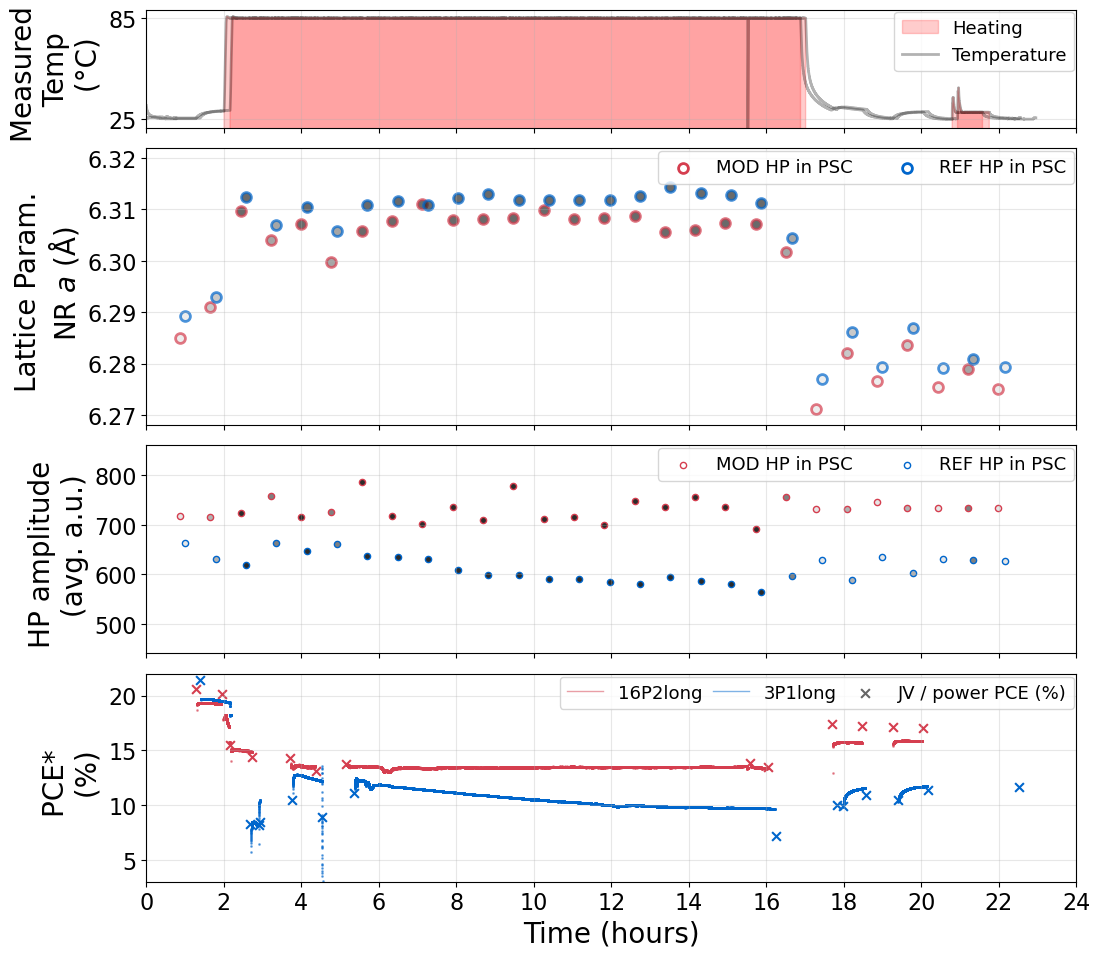

In [ ]:
#LARGE CREATION OF A FIGURE WITH ALL THE TIME-RESOLVED DATA on a timeline from the start to end of experiment, comparison of two devices/samples

#color_list = ['red', 'steelblue']
color_list = ['#D53E4F','#0066CC'] # 'Modified':     # Deep red, 'Reference': , '#3288BD' # Strong blue   '#0066CC',  # Strong, saturated blue
mod_list = ['MOD', 'REF']
    # Create figure with shared x-axis
fig, axs= plt.subplots(4,1, figsize=(12, 8), sharex=True, height_ratios=[1.7, 4, 3, 3])
plt.subplots_adjust(top=1.2, hspace=0.1)


ax1 = axs[1]
ax_amp = axs[2]
ax2 = axs[0]
ax3 = axs[3]

#colors = {'ON-HIGH': '#E69F00', 'ON-LOW': '#56B4E9', 'OFF-HIGH': '#009E73', 'OFF-LOW': '#CC79A7'}
'''colors = {
    'ON-HIGH': '#E67300', # Deep burnt orange'#FFB84D',  # Bright orange-gold '#FFA666',  # More saturated peach '#FFB787',  # Lighter peach tone'#E8876C',  # Coral/orange instead of yellow'#FDB863',  # Orange
    'ON-LOW': '#2E8B57',   # Strong saturated forest green '#7AB85C',   # Strong lime-sage'#9FB754',   # Brighter sage/olive'#B5C99A',   # Sage/olive'#E5C1CF',   # Dusty rose '#A3BFE0',   # Stronger steel blue'#C2D4E5',   # Cool gray-blue'#B8D9C8',   # Cool mint/sage'#B2ABD2',   # Light purple
    'OFF-HIGH': '#C0C5C9', # Cool steel gray'#D4D4D4', # Warm mid-gray'#E8D0B3', # Warmer light beige'#F5E6D3', # Very light beige '#E09245', # Deep amber'#E7C088', # Richer beige '#E7D4B5', # Warm beige/tan '#80CDC1', # Teal
    'OFF-LOW': '#C5D5A3'   # Warm, homey sage green'#B8D4B3'   # Light but defined sage green'#D8E8D5'   # Pale sage green'#98D668'   # Vibrant green'#C8E199'   # More vibrant light green'#DCEDC8'   # Light green
}'''
colors = {
    'OFF-LOW': '#E6E6E6',   # Very light gray
    'ON-LOW': '#B3B3B3', # Light gray'
    'OFF-HIGH': '#808080',   # Medium gray
    'ON-HIGH': '#2B2B2B'  # Very dark gray
}

labels = []#['OFF-LOW','ON-LOW','OFF-HIGH', 'ON-HIGH']

for start_tim, nR, temp_d, light_d, monitor_d, iv_match, col in zip(start_lis, nr_list, temp_df_list, light_df_list, monitor_df_list, iv_list, color_list):
    temp_d['seconds'] = (temp_d['Time'] - start_tim).dt.total_seconds()
    light_d['seconds'] = (light_d['Time'] - start_tim).dt.total_seconds()
    monitor_d['seconds'] = (monitor_d['Time'] - start_tim).dt.total_seconds()
    iv_match['seconds'] = (iv_match['jv_time'] - start_tim).dt.total_seconds()
    ax1, ax2, ax3, ax_amp = time_fig_grandi(ax1, ax2, ax3, ax_amp, colors, start_tim, nR, temp_d, light_d, monitor_d, iv_match, col)


for label in labels:
    ax1.scatter([], [], fc=colors[label], ec='w', lw=3, alpha=0.8, label=label, s = 50)
for coli, va in zip(color_list, mod_list): 
    ax1.scatter([], [], fc='w', ec=coli, s=50, lw=2, label = va +' HP in PSC')
    ax_amp.scatter([], [], fc='w', ec=coli, lw=1, label=va +' HP in PSC', s=20)
ax3.scatter([], [], color = 'k', alpha = 0.6, marker = 'x', s=40, label = 'JV / power PCE (%)')  #alpha = 0.5, 
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/3600)))
ax3.xaxis.set_major_locator(plt.MultipleLocator(7200))
ax3.set_xlim(0, 86400)
ax2.fill_between([], [], color='red', alpha =0.2, label='Heating')
ax2.plot([], [], 'k-', alpha=0.3, lw=2, label = 'Temperature')
ax3.legend(loc = 'upper right', fontsize=13, bbox_to_anchor=(1.007, 1.03), ncols=3, columnspacing=0.6, frameon=True)
ax2.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.007, 1.06))
ax1.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.007, 1.02), ncols=2, frameon=True)  #title='state:   Light - Heat'
ax_amp.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.007, 1.03), ncols=2, frameon=True)

ax_amp.grid(True, alpha=0.3)
ax_amp.set_ylabel('HP amplitude \n (avg. a.u.)', fontsize=20)
ax_amp.set_ylim(440, 860)
ax_amp.set_yticks([500, 600, 700, 800])
ax_amp.tick_params(axis='both', which='major', labelsize=16)
ax_amp.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/3600)))
ax_amp.xaxis.set_major_locator(plt.MultipleLocator(7200)) # 3600
ax_amp.set_xlim(0,86400)  #  24000


In [32]:
#print(iv_matches[['jv_time', 'pce']])

In [33]:
#print(iv_list[0][['jv_time', 'pce']])

In [34]:
#Definition of what iv-curves should be plotted to endsure IV-curves are taking at the same time for each variation depending on the experiment (for comparison between two experiments)

for i in range(len(iv_list)):
    iv = iv_list[i]
    start_time = start_lis[i]
    iv['time_since_start'] = iv['jv_time']-start_time

points = [[pd.Timedelta('0 days 00:00:00'),pd.Timedelta('0 days 02:00:00')],[pd.Timedelta('0 days 02:10:00'),pd.Timedelta('0 days 03:30:00')], [pd.Timedelta('0 days 04:50:00'),pd.Timedelta('0 days 06:00:00')], [pd.Timedelta('0 days 15:00:00'),pd.Timedelta('0 days 17:00:00')], [pd.Timedelta('0 days 18:00:00'),pd.Timedelta('0 days 21:00:00')]]

#points = [[pd.Timedelta('0 days 00:00:00'),pd.Timedelta('0 days 02:00:00')], [pd.Timedelta('0 days 04:50:00'),pd.Timedelta('0 days 06:00:00')], [pd.Timedelta('0 days 15:00:00'),pd.Timedelta('0 days 17:00:00')], [pd.Timedelta('0 days 18:00:00'),pd.Timedelta('0 days 21:00:00')]]


#print(iv_list[0])
print(points[0][0] <= iv_list[0]['time_since_start'].iloc[2] <= points[0][1])

#help(iv_list[0]['time_since_start'].iloc[0])

True


0 days 01:16:59
0 days 02:43:53
0 days 05:09:33
0 days 15:34:19
0 days 18:28:17
              NR_time     state             jv_time  type  \
0 2025-01-28 16:48:46    ON-LOW 2025-01-28 16:25:36  dark   
0 2025-01-28 18:22:38  OFF-HIGH 2025-01-28 17:59:27  dark   
0 2025-01-28 18:22:38  OFF-HIGH 2025-01-28 18:42:05  dark   
0 2025-01-28 19:09:34   ON-HIGH 2025-01-28 18:49:01  dark   
0 2025-01-28 19:56:30  OFF-HIGH 2025-01-28 19:33:27  dark   
0 2025-01-28 19:56:30  OFF-HIGH 2025-01-28 20:14:49  dark   
0 2025-01-29 07:40:26  OFF-HIGH 2025-01-29 07:17:00  dark   
0 2025-01-29 07:40:26  OFF-HIGH 2025-01-29 08:00:37  dark   
0 2025-01-29 08:27:20   OFF-LOW 2025-01-29 08:04:24  dark   
0 2025-01-29 09:14:16    ON-LOW 2025-01-29 08:49:55  dark   
0 2025-01-29 10:01:12   OFF-LOW 2025-01-29 09:39:51  dark   
0 2025-01-29 10:01:12   OFF-LOW 2025-01-29 10:22:48  dark   
0 2025-01-29 11:35:04   OFF-LOW 2025-01-29 11:13:29  dark   
0 2025-01-29 11:35:04   OFF-LOW 2025-01-29 11:56:25  dark   
0 202

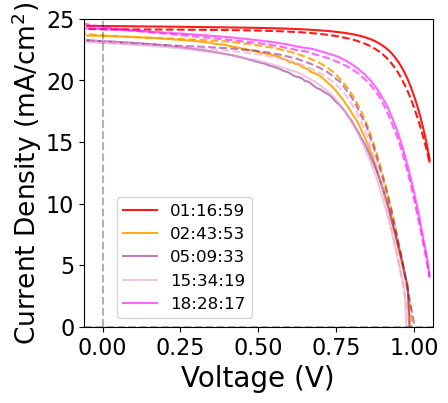

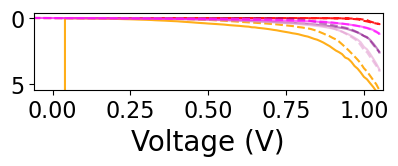

In [35]:
#Creation of IV-plot for one of the devices (Modification)

color_li =  ['red', 'orange','purple', "#E4A1D2", 'magenta','green','grey', 'gray'] # '#800080',['gray','red','orange', 'yellow','blue','green','purple',] #['red', 'orange','purple', '#9B2C7D', 'orange', 'red','green','grey', 'gray']
#color_li = [(0.101, 0.140, 0.057), (0.173, 0.093, 0.175), (0.204, 0.168, 0.197), (0.169,0.209,0.142), (0.130, 0.058, 0.059)]

alpha_li = [0.9,0.9,0.5,0.6,0.6,0.7,0.8,0.9]
#colarray = ['red', 'orangered']
iv = iv_list[0]
iv_l = iv[iv['type']=='light']
iv_d = iv[iv['type']=='dark']  
start_time = start_lis[0]


fig = plt.figure(figsize=(4.5,4))
ax1 = fig.gca()
ax1.set_ylim(0, 25)     #ax1.set_ylim(0.001, -0.004)ax1.set_xlim(-0.1, 1.1)
ax1.set_xlim(-0.06, 1.06)
ax1.set_xlabel('Voltage (V)', fontsize=20)
ax1.set_ylabel('Current Density (mA/cm$^{2}$)', fontsize=19, labelpad=1)
#axins = ax1.inset_axes([0.12, 0.35, 0.31, 0.31])
#axins.set_xlim(-0.12, 0.22)  # Narrow voltage window around 0V
#axins.set_ylim(22.1, 25) 
#iv_plot = iv_l.iloc[[0,1,2,3,4,5,6,7,10]]   #[[0,1,2,3,4,6,7,8]]    
for index, c,a in zip(range(len(points)), color_li, alpha_li):   
    done = 0
    for t in iv_l['time_since_start'].unique():
        if done == 1: 
            continue
        if points[index][0] <= t <= points[index][1]:
            row = iv_l[iv_l['time_since_start']==t]
            print(t)    
            ax1.plot(row['voltage'].iloc[0],row['current'].iloc[0]/-0.00016, color = c, alpha=a, label= str(row['time_since_start'].iloc[0])[-8:])
            ax1.plot(row['v_fw'].iloc[0],row['c_fw'].iloc[0]/-0.00016, '--', color = c, alpha=a)
            done+=1
    #axins.plot(row['voltage'].iloc[0],row['current'].iloc[0]/-0.00016, color = c, label= row['state'].iloc[0]+'    '+str(row['jv_time'].iloc[0])[-8:])
    #axins.plot(row['v_fw'].iloc[0],row['c_fw'].iloc[0]/-0.00016, '--', color = c, alpha=a)
ax1.legend(loc='lower left', fontsize=12,  bbox_to_anchor=(0.07, 0), frameon=True)
#ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
#axins.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
ax1.hlines(y=0, xmin=-0.2, xmax =2, color='black', alpha = 0.3, linestyle='--')
ax1.vlines(x=0, ymin=-10, ymax=30, color='black', alpha = 0.3, linestyle='--')
#axins.vlines(x=0, ymin=-10, ymax=30, color='black', alpha = 0.3, linestyle='--')
ax1.tick_params(axis='both', labelsize=16)
#axins.tick_params(axis='both', labelsize=14)


print(iv_d)
fig2 = plt.figure(figsize=(4.5,1))
ax2 = fig2.gca()
#ax2.set_yscale('log')
ax2.set_ylim(5.4, -0.4)   #0.00000001
ax2.set_yticks([0, 5])   #0.00000001
ax2.set_xlim(-0.06, 1.06)
ax2.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_xlabel('Voltage (V)', fontsize=20)
#ax2.set_ylabel('Current (mA)', fontsize=20)
#axins = ax1.inset_axes([0.07, 0.55, 0.3, 0.3])
#axins.set_xlim(-0.09, 0.19)  # Narrow voltage window around 0V
#axins.set_ylim(-0.0035, -0.00405) 
#iv_plt = iv_d.iloc[[0,2,3,4,5,6]]    #Removed 4, 13
for index, c, a in zip(range(len(points)), color_li, alpha_li):
    done = 0
    for t in iv_d['time_since_start'].unique():
        if done ==1: 
            continue
        if points[index][0] <= t <= points[index][1]:
            row = iv_d[iv_d['time_since_start']==t]    
            ax2.plot(row['voltage'].iloc[0],row['current'].iloc[0]*1000, '--', alpha=a, color = c, label= str(t)[-8:])
            ax2.plot(row['v_rv'].iloc[0],row['c_rv'].iloc[0]*1000, '-', color = c, alpha=a)
            done +=1
    #axins.plot(row['voltage'].iloc[0],row['current'].iloc[0], color = c, label= row['state'].iloc[0]+' - '+str(row['jv_time'].iloc[0])[-8:])
#ax2.legend(loc='lower left', fontsize=12) #bbox_to_anchor=(0,1)
ax2.tick_params(axis='both', which='major', labelsize=16)
#ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
#axins.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
#ax1.hlines(y=0, xmin=-0.2, xmax =2, color='black', alpha = 0.2, linestyle='--')
#ax1.vlines(x=0, ymin=0.2, ymax=-0.02, color='black', alpha = 0.2, linestyle='--')

0 days 01:23:26
0 days 02:41:03
0 days 05:21:17
0 days 16:15:44
0 days 18:34:26
              NR_time     state             jv_time  type  \
0 2025-01-27 17:35:16   OFF-LOW 2025-01-27 17:56:57  dark   
0 2025-01-27 19:56:04  OFF-HIGH 2025-01-27 19:32:31  dark   
0 2025-01-27 19:56:04  OFF-HIGH 2025-01-27 20:17:37  dark   
0 2025-01-27 21:29:54  OFF-HIGH 2025-01-27 21:08:42  dark   
0 2025-01-27 22:16:50   ON-HIGH 2025-01-27 21:54:16  dark   
0 2025-01-28 09:13:50  OFF-HIGH 2025-01-28 08:54:09  dark   
0 2025-01-28 09:13:50  OFF-HIGH 2025-01-28 09:33:10  dark   
0 2025-01-28 10:00:46   OFF-LOW 2025-01-28 09:36:31  dark   
0 2025-01-28 10:00:46   OFF-LOW 2025-01-28 10:22:22  dark   
0 2025-01-28 11:34:38   OFF-LOW 2025-01-28 11:55:37  dark   
0 2025-01-28 11:34:38   OFF-LOW 2025-01-28 11:11:20  dark   
0 2025-01-28 13:08:28   OFF-LOW 2025-01-28 12:45:52  dark   
0 2025-01-28 13:08:28   OFF-LOW 2025-01-28 13:29:59  dark   
0 2025-01-28 13:55:24  OFF-HIGH 2025-01-28 13:35:18  dark   
0 202

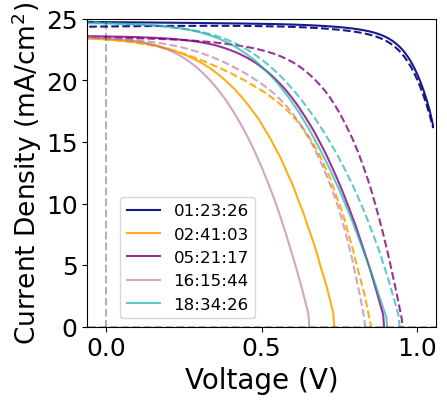

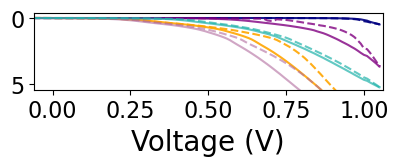

In [36]:
#Creation of IV-plot for one of the devices (Reference)

color_li = ['navy', 'orange','purple', "#B16B9E", 'lightseagreen','green','grey', 'gray']#['navy', 'orange', 'purple', "#532C9B", 'steelblue','green','grey', 'gray'] ['navy','#800080','#9B2C7D', 'steelblue','green','purple','grey', 'yellow']     #['gray','red','orange', 'yellow','blue','green','purple',]
alpha_li = [0.9,0.9,0.8,0.6,0.7,0.7,0.8,0.9]
#colarray = ['navy', 'steelblue',]
iv = iv_list[1]
iv_l = iv[iv['type']=='light']
iv_d = iv[iv['type']=='dark'] 
start_time = start_lis[0]

#print(iv_l)
fig = plt.figure(figsize=(4.5, 4))
ax1 = fig.gca()
ax1.set_xlabel('Voltage (V)', fontsize=20)
ax1.set_ylabel('Current Density (mA/cm$^{2}$)', fontsize=19, labelpad=1)
ax1.set_ylim(0, 25)
ax1.set_xlim(-0.06, 1.06)
#axins = ax1.inset_axes([0.12, 0.35, 0.31, 0.31])
#axins.set_xlim(-0.12, 0.22)  # Narrow voltage window around 0V
#axins.set_ylim(22.1, 25) 
#iv_plot = iv_l.iloc[[0,1,2,3,4,5,6,7,8]]    #[[0,1,6,7,8,13]]
for index, c,a in zip(range(len(points)), color_li, alpha_li):  
    done = 0
    for t in iv_l['time_since_start'].unique():
        if done ==1: 
            continue
        if points[index][0] <= t <= points[index][1]:
            row = iv_l[iv_l['time_since_start']==t]
            print(t)    
            ax1.plot(row['voltage'].iloc[0],row['current'].iloc[0]/-0.00016, color = c, alpha=a, label= str(t)[-8:])
            ax1.plot(row['v_fw'].iloc[0],row['c_fw'].iloc[0]/-0.00016, '--', color = c, alpha=a)
            done +=1
    #axins.plot(row['voltage'].iloc[0],row['current'].iloc[0]/-0.00016, color = c)
ax1.legend(loc='lower left', fontsize=12, bbox_to_anchor=(0.07, 0), frameon=True)
#ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
#axins.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
ax1.hlines(y=0, xmin=-0.2, xmax =2, color='black', alpha = 0.3, linestyle='--')
ax1.vlines(x=0, ymin=-10, ymax=30, color='black', alpha = 0.3, linestyle='--')
ax1.tick_params(axis='both', labelsize=18)
#axins.tick_params(axis='both', labelsize=14)

print(iv_d)
fig2 = plt.figure(figsize=(4.5, 1))
ax2 = fig2.gca()
ax2.set_xlabel('Voltage (V)', fontsize=20)
#ax2.set_ylabel('Current (mA)', fontsize=20)
#ax2.set_yscale('log')
ax2.set_ylim(5.4, -0.4)   #0.00000001
ax2.set_yticks([0, 5])   #0.00000001
ax2.set_xlim(-0.06, 1.06)
ax2.set_xticks([0, 0.25, 0.5, 0.75, 1])
#axins = ax1.inset_axes([0.07, 0.55, 0.3, 0.3])
#axins.set_xlim(-0.09, 0.19)  # Narrow voltage window around 0V
#axins.set_ylim(-0.0035, -0.00405) 
#iv_plt = iv_d.iloc[[0,1,2,3,4,5,6]]
for index, c,a in zip(range(len(points)), color_li, alpha_li):  
    done = 0
    for t in iv_d['time_since_start'].unique():
        if done ==1: 
            continue
        if points[index][0] <= t <= points[index][1]:
            row = iv_d[iv_d['time_since_start']==t]    
            ax2.plot(row['voltage'].iloc[0],row['current'].iloc[0]*1000, '--', color = c, alpha=a, label= str(t)[-8:])
            ax2.plot(row['v_rv'].iloc[0],row['c_rv'].iloc[0]*1000, color = c, alpha=a)
            done +=1
    #axins.plot(row['voltage'].iloc[0],row['current'].iloc[0], color = c, label= row['state'].iloc[0]+' - '+str(row['jv_time'].iloc[0])[-8:])
#ax2.legend(loc='upper left', fontsize=12, bbox_to_anchor=(0,1))
ax2.tick_params(axis='both', labelsize=16)
#ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
#axins.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:.0f}'.format(x/0.00016)))
#ax1.hlines(y=0, xmin=-0.2, xmax =2, color='black', alpha = 0.2, linestyle='--')
#ax1.vlines(x=0, ymin=0.2, ymax=-0.02, color='black', alpha = 0.2, linestyle='--')

This is the end of the main analysis, 
the other cells below is useful, but not as detailed

In [ ]:
#This older code for plotting the XRD in a more manual fashion, selecting the states and XRD scan number manually

xrd_assets = list(filter(lambda asset: asset.file.endswith("xrdml"), assets))
'''xrd1 = list(filter(lambda asset: "01" in asset.file, xrd_assets))[0]
xrd2 = list(filter(lambda asset: "02" in asset.file, xrd_assets))[0]
xrd15 = list(filter(lambda asset: "15" in asset.file, xrd_assets))[0]
xrd40 = list(filter(lambda asset: "40" in asset.file, xrd_assets))[0]
xrd50 = list(filter(lambda asset: "50" in asset.file, xrd_assets))[0]
xrd62 = list(filter(lambda asset: "62" in asset.file, xrd_assets))[0]
xrd63 = list(filter(lambda asset: "63" in asset.file, xrd_assets))[0]
xrd65 = list(filter(lambda asset: "65" in asset.file, xrd_assets))[0]'''

xrd1 = list(filter(lambda asset: "01" in asset.file, xrd_assets))[0]
xrd6 = list(filter(lambda asset: "06" in asset.file, xrd_assets))[0]
xrd11 = list(filter(lambda asset: "11" in asset.file, xrd_assets))[0]
xrd16 = list(filter(lambda asset: "16" in asset.file, xrd_assets))[0]
xrd22 = list(filter(lambda asset: "22" in asset.file, xrd_assets))[0]
xrd27 = list(filter(lambda asset: "27" in asset.file, xrd_assets))[0]
xrd32 = list(filter(lambda asset: "32" in asset.file, xrd_assets))[0]
xrd37 = list(filter(lambda asset: "37" in asset.file, xrd_assets))[0]
xrd42 = list(filter(lambda asset: "42" in asset.file, xrd_assets))[0]
xrd57 = list(filter(lambda asset: "57" in asset.file, xrd_assets))[0]
xrd58 = list(filter(lambda asset: "58" in asset.file, xrd_assets))[0]
xrd59 = list(filter(lambda asset: "59" in asset.file, xrd_assets))[0]

'''xrd1 = list(filter(lambda asset: "01" in asset.file, xrd_assets))[0]
xrd10 = list(filter(lambda asset: "10" in asset.file, xrd_assets))[0]
xrd18 = list(filter(lambda asset: "18" in asset.file, xrd_assets))[0]
xrd27 = list(filter(lambda asset: "27" in asset.file, xrd_assets))[0]
xrd35 = list(filter(lambda asset: "35" in asset.file, xrd_assets))[0]
xrd44 = list(filter(lambda asset: "44" in asset.file, xrd_assets))[0]
xrd53 = list(filter(lambda asset: "53" in asset.file, xrd_assets))[0]
xrd62 = list(filter(lambda asset: "62" in asset.file, xrd_assets))[0]
xrd64 = list(filter(lambda asset: "64" in asset.file, xrd_assets))[0]
xrd65 = list(filter(lambda asset: "65" in asset.file, xrd_assets))[0]'''

#arr_list = [xrd1, xrd2, xrd15, xrd40, xrd50, xrd62, xrd63, xrd65]
#cond_list = [['dark','RT'],['1 sun', 'RT'], ['1 sun', 85], ['dark', 85], ['dark',85], ['1 sun',85], ['1 sun', 'RT'], ['dark','RT']]
#range_list = [[11,44],[19.3, 32], [19.3, 32], [19.3, 32], [19.3, 32], [11, 44], [19.3, 32], [11, 44]]
arr_list = [xrd1, xrd6, xrd11,xrd16,xrd22,xrd27,xrd32,xrd37, xrd42, xrd57, xrd58, xrd59]
cond_list = [['dark','RT'],['1 sun', 70], ['1 sun', 85], ['1 sun', 85],['1 sun', 85],['1 sun', 85],['1 sun', 85],['1 sun', 85],['1 sun', 85], ['dark',85], ['1 sun','cooling'], ['dark', 'cooling']]
range_list = [[10,44],[10,44], [10,44], [10,44],[10,44],[10,44],[10,44],[10,44],[10,44], [10,44], [10,44], [10,44]]
#arr_list = [xrd1, xrd10, xrd18,xrd27,xrd35,xrd44,xrd53,xrd62, xrd64, xrd65]
#cond_list = [['dark','RT'],['1 sun', 75], ['1 sun', 85], ['1 sun', 85],['1 sun', 85],['dark', 85],['dark', 85],['1 sun', 85],['1 sun', 'cooling'], ['dark','cooling']]
#range_list = [[10,44],[10,44], [10,44], [10,44],[10,44],[10,44],[10,44],[10,44],[10,44], [10,44]]

d_values = []
a_values = []
df_input = pd.DataFrame()
index = 0
for ass in arr_list: 
    new_frame = XRDframe(ass, light=cond_list[index][0], temp=cond_list[index][1])
    new_frame['range_low'] = range_list[index][0]
    new_frame['range_high'] = range_list[index][1]
    #new_row = pd.DataFrame(new_frame, index=[index])
    df_input = pd.concat([df_input, new_frame], ignore_index=False)
    index+=1  

        
ref_ftoAvalue = df_input['a_value_fto110'].mean()   #The average a value of the FTO110 peak is the reference
print('The reference for relative translation is a_value ', ref_ftoAvalue, ' Angstrom')

rel_a = []
a_corr = []
i = 0
while i < df_input.index.size:
    a = df_input['a_value_fto110'].iloc[i]
    a_rel = a/ref_ftoAvalue
    rel_a.append(a_rel)
    corr_a = a / a_rel
    a_corr.append(corr_a)
    i+=1
df_input.insert(3, 'rel_a', rel_a)
df_input.insert(4, 'corr_a', a_corr)
pd.set_option('display.max_columns',100)
print(df_input)

The reference for relative translation is a_value  4.794738046975625  Angstrom
                                                File  \
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   
0  \\?\C:\Users\fbaumann\PyProjects_AMZ\Project2\...   

                 start_time                  end_time     rel_a    corr_a  \
0 2024-11-28 09:45:28+01:00 2024-11-28 10:26:38+01:00  1.012858  4.794738   
0 2025-01-28 19:33:10+01:00 2025-01-28

['delta', 'i2Pb', 'p(001)', 'p(011)', 'unknown', 'p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004'] [[11.5, 11.8], [12, 12, 9], [13, 15], [19, 20], [21, 23], [24, 25], [26, 27], [27.7, 29], [30, 31], [31, 32], [33, 34], [34, 36], [37, 37.8], [37.8, 39], [39, 40], [40, 41], [42, 43], [43, 45], [48, 50.5], [50.5, 52], [52, 55], [55, 60]] 11 43 19 4.803231432910652
                  start_time light     temp      Peak        pos    amplitude  \
0  2024-11-27 12:48:37+01:00  dark       RT   Unknown  12.367516   575.124453   
1  2024-11-27 12:48:37+01:00  dark       RT    p(001)  13.702410   693.406376   
2  2024-11-27 12:48:37+01:00  dark       RT    p(011)  19.687081   769.406062   
3  2024-11-27 12:48:37+01:00  dark       RT    p(111)  24.228698   383.556848   
4  2024-11-27 12:48:37+01:00  dark       RT  FTO(110)  26.241031  1179.745760   
..                       ...   ...      ...       ...     

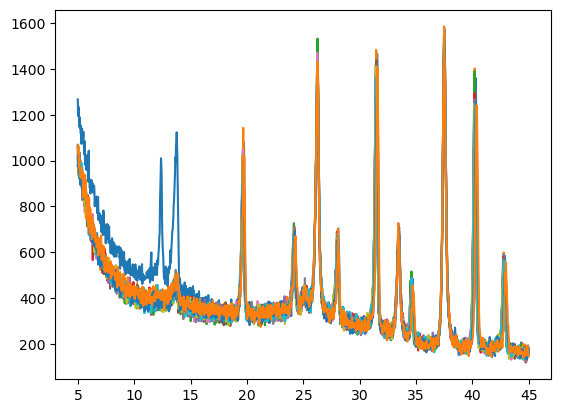

In [ ]:
#Defining the parameters of the experiment: Variation and what peaks are expected in what range of the scans.
variations = ['Ref','Mod']
max_num_peaks_per_sample = 19
peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12,9], [13,15], [19,20], [21,23], [24,25], [26,27],[27.7,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43], [43,45], [48,50.5], [50.5,52], [52,55],[55,60]]

df_list = [df_input]
df_ranges = [[11, 43]]
maxpeaks = [19]

#Creating a dataframe and fitting the data
result_df = pd.DataFrame()   #columns=['Sample', 'Variation', 'Peak', 'pos', 'amplitude', 'stdvG', 'd_value','a_rel', 'rel_a']
i = 0 
ythres=200
while i < len(df_list):
    print(peak_names, peak_ranges, df_ranges[i][0], df_ranges[i][1], maxpeaks[i], ref_ftoAvalue)
    new_result_df = framefit(df_list[i], peak_names, peak_ranges, maxpeaks[i], ref_ftoAvalue, ythres, pl=False)
    result_df = pd.concat([result_df, new_result_df])
    i+=1
print(result_df)

In [136]:
#Calculating and adjusting a-values

a_values_raw = []
a_aligned = []
i = 0
while i < result_df.index.size: 
    d = result_df['d_value'].iloc[i]
    peak = result_df['Peak'].iloc[i]
    rel_a  = result_df['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_df['a_raw'] = a_values_raw
result_df['a_final'] = a_aligned
print(result_df)

                  start_time light     temp      Peak        pos    amplitude  \
0  2024-11-27 12:48:37+01:00  dark       RT   Unknown  12.367516   575.124453   
1  2024-11-27 12:48:37+01:00  dark       RT    p(001)  13.702410   693.406376   
2  2024-11-27 12:48:37+01:00  dark       RT    p(011)  19.687081   769.406062   
3  2024-11-27 12:48:37+01:00  dark       RT    p(111)  24.228698   383.556848   
4  2024-11-27 12:48:37+01:00  dark       RT  FTO(110)  26.241031  1179.745760   
..                       ...   ...      ...       ...        ...          ...   
5  2024-11-28 08:34:04+01:00  dark  cooling     (211)  33.441118   475.652790   
6  2024-11-28 08:34:04+01:00  dark  cooling    defect  34.723347   237.791500   
7  2024-11-28 08:34:04+01:00  dark  cooling      FTO3  37.492753  1331.598613   
8  2024-11-28 08:34:04+01:00  dark  cooling    p(022)  40.363099  1077.727375   
9  2024-11-28 08:34:04+01:00  dark  cooling    p(003)  42.953256   376.281563   

       stdvG   d_value     

Text(0, 0.5, 'Intensity (counts)')

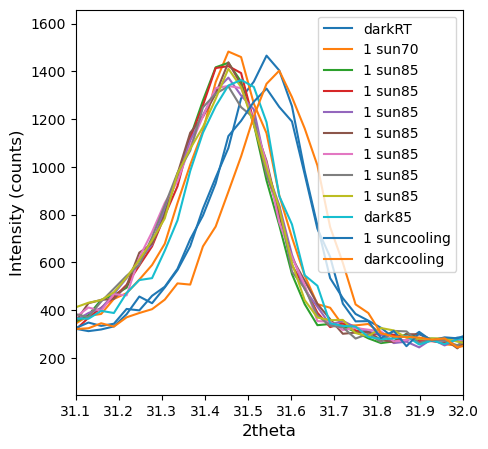

In [ ]:
#Creating a plot with the XRD spectra of a certain peak

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
for start in df_input['start_time'].unique():
    data = df_input[df_input['start_time']==start]
    ax.plot(data['x_array'].iloc[0], data['y_array'].iloc[0], label=data['light'].iloc[0]+str(data['temperature'].iloc[0]))



ax.set_xlim([31.1,32])
ax.legend()
ax.set_xlabel('2theta', fontsize = 12)
ax.set_ylabel('Intensity (counts)', fontsize = 12)

1     13.702410
2     19.687081
3     24.228698
5     28.077044
6     31.529145
10    40.297467
11    42.869633
Name: pos, dtype: float64
dark RT [6.270923685952478] 6.270923685952478
0    19.647739
1    24.180061
3    28.020741
4    31.459400
8    40.204827
9    42.768445
Name: pos, dtype: float64
1 sun 70 [6.3093137768378105] 6.3093137768378105
0    19.624348
1    24.151623
3    27.991187
4    31.436099
8    40.177131
9    42.746997
Name: pos, dtype: float64
1 sun 85 [6.309750737609324] 6.309750737609324
0    19.623406
1    24.152593
3    28.000586
4    31.441112
8    40.188166
9    42.755913
Name: pos, dtype: float64
1 sun 85 [6.306827700243835] 6.306827700243835
0    19.625924
1    24.164526
3    27.993007
4    31.440101
8    40.188867
9    42.765019
Name: pos, dtype: float64
1 sun 85 [6.307208297712015] 6.307208297712015
0    19.623152
1    24.146908
3    27.988331
4    31.440271
8    40.188933
9    42.758468
Name: pos, dtype: float64
1 sun 85 [6.30639277838622] 6.30639277838622
0

<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20832\2958622560.py:17: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


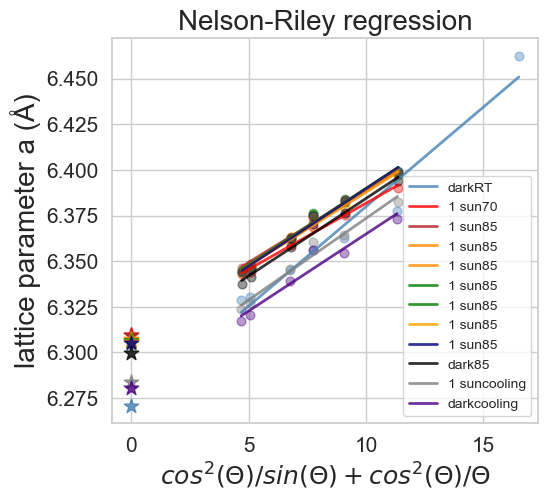

In [ ]:
#Nelson-Riley figure

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red','firebrick', 'darkorange', 'darkorange','green','green','orange','navy', 'black','grey', 'indigo']
col_ind = 0
nr = pd.DataFrame()
for time in result_df['start_time'].unique():   
    data = result_df[result_df['start_time']==time]
    c = nelson_riley(data, ax, col_array[col_ind], 'a_raw', 'pos', alp=0.8, lab=data['light'].iloc[0]+str(data['temp'].iloc[0]))
    col_ind+=1
    #nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    #nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.25,6.32)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='lower right', fontsize=10)  
#print(nr)

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20832\3788181526.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_20832\3788181526.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


KeyError: 'Sample'

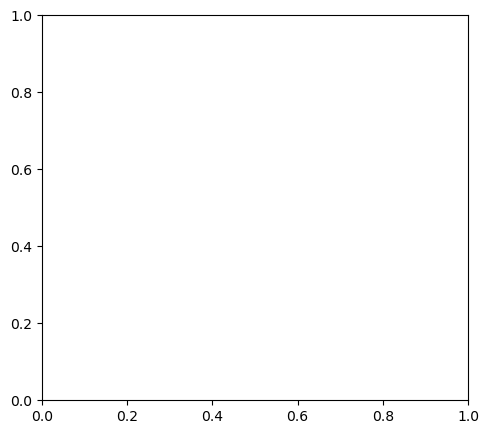

In [ ]:
#Nelson-Riley figure,another option

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black','green','orange','grey']
col_ind = 0
nr = pd.DataFrame()
for samp in result_df['Sample'].unique():   #)
    sample = result_df[result_df['Sample']==samp]
    if sample['Variation'].iloc[0]=='Mod':
        c = nelson_riley(sample,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.8, lab=samp)
    if sample['Variation'].iloc[0]=='Ref':
        c = nelson_riley(sample,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.2, lab=samp)
    col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
ax.set_ylim(6.26,6.29)
ax.set_xlim(-0.5,1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper right', fontsize=12)  
print(nr)
fig2, ax2 = plt.subplots(figsize=(3,7))
nr.boxplot(column='intercept', by='Variation', ax=ax2, boxprops=dict(color='blue'))

In [ ]:
#Plotting only ON values

condi_ON = list(filter(lambda asset: asset.file.endswith('On.xrdml'), xrd_assets))
df_ON = pd.DataFrame()
index = 0
for ass in condi_ON:
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    two_theta, y, start_time, end_time = readXRDML(file)
    start = pd.to_datetime(start_time)
    end = pd.to_datetime(end_time)
    center, amplitude, stddev, peak_count = fit_XRD(two_theta, y, low_Xthres=25.8, high_Xthres=27.5, maxpeaks=5, y_thres=400, Fitplot=False)
    d = braggs(center[0])
    d_values.append(d)
    a = (a_value(d, 1, 1, 0))
    a_values.append(a)
    new_input = {
        'File':file,
        'FTO110_pos': center[0], 
        'Sample': samp,
        'Variation': var,
        'light':'dark',
        'temperature':'RT', 
        'd_value_fto110': d,
        'a_value_fto110':a, 
        'x_array': two_theta, 
        'y_array':y,
        'rel_a':1
    }
    index+=1
    new_row = pd.DataFrame([new_input], index=[index])
    df_ON = pd.concat([df_ON, new_row], ignore_index=True)
print(df_ON['x_array'].values)

[array([10.01477157, 10.04431471, 10.07385784, ..., 44.93475842,
        44.96430155, 44.99384469])
 array([10.01477157, 10.04431471, 10.07385784, ..., 44.93475842,
        44.96430155, 44.99384469])
 array([10.01477157, 10.04431471, 10.07385784, ..., 44.93475842,
        44.96430155, 44.99384469])                              ]


In [309]:
#Defining the parameters of the experiment: Variation and what peaks are expected in what range of the scans.
variations = ['Ref','Mod']
max_num_peaks_per_sample = 19
peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12,9], [13,15], [19,20], [21,23], [24,25], [26,27],[28,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43], [43,45], [48,50.5], [50.5,52], [52,55],[55,60]]

df_list = [df_ON]
df_ranges = [[10.5, 44]]
maxpeaks = [19]

#Creating a dataframe and fitting the data
result_ON = pd.DataFrame()   #columns=['Sample', 'Variation', 'Peak', 'pos', 'amplitude', 'stdvG', 'd_value','a_rel', 'rel_a']
i = 0 
ythres=200
while i < len(df_list):
    new_result_df = framefit(df_list[i], peak_names, peak_ranges, df_ranges[i][0], df_ranges[i][1], maxpeaks[i], ref_ftoAvalue, ythres, pl=False)
    result_ON = pd.concat([result_ON, new_result_df])
    i+=1
print(result_ON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP14       Mod    p(001)  13.349445   208.184027  1.017018  6.632711   
1    DP14       Mod    p(001)  13.916942   215.905857  0.834897  6.363497   
2    DP14       Mod    p(001)  14.529940   205.113935  1.017420  6.096380   
3    DP14       Mod   Unknown  15.097016   208.272304  0.695422  5.868640   
4    DP14       Mod   Unknown  16.076815   172.573794  1.083027  5.513116   
5    DP14       Mod   Unknown  25.949068   699.564352  0.240583  3.433743   
6    DP14       Mod   Unknown  27.711799   289.512566  0.363648  3.219202   
7    DP14       Mod    p(012)  31.157245  1050.361518  0.238665  2.870628   
8    DP14       Mod     (211)  33.181318   453.732145  0.221945  2.700001   
9    DP14       Mod    defect  34.291469   251.402199  0.161765  2.615091   
10   DP14       Mod      FTO3  37.728165  4874.007347  0.309719  2.384408   
11   DP14       Mod       Au2  39.911322  1076.643715  0.197228  2.258872   

In [311]:
#Calculating and adjusting a-values

a_values_raw = []
a_aligned = []
i = 0
while i < result_ON.index.size: 
    d = result_ON['d_value'].iloc[i]
    peak = result_ON['Peak'].iloc[i]
    rel_a  = result_ON['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_ON['a_raw'] = a_values_raw
result_ON['a_final'] = a_aligned
print(result_ON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP14       Mod    p(001)  13.349445   208.184027  1.017018  6.632711   
1    DP14       Mod    p(001)  13.916942   215.905857  0.834897  6.363497   
2    DP14       Mod    p(001)  14.529940   205.113935  1.017420  6.096380   
3    DP14       Mod   Unknown  15.097016   208.272304  0.695422  5.868640   
4    DP14       Mod   Unknown  16.076815   172.573794  1.083027  5.513116   
5    DP14       Mod   Unknown  25.949068   699.564352  0.240583  3.433743   
6    DP14       Mod   Unknown  27.711799   289.512566  0.363648  3.219202   
7    DP14       Mod    p(012)  31.157245  1050.361518  0.238665  2.870628   
8    DP14       Mod     (211)  33.181318   453.732145  0.221945  2.700001   
9    DP14       Mod    defect  34.291469   251.402199  0.161765  2.615091   
10   DP14       Mod      FTO3  37.728165  4874.007347  0.309719  2.384408   
11   DP14       Mod       Au2  39.911322  1076.643715  0.197228  2.258872   

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_6264\255164215.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


Mod [6.282895575021049] 6.282895575021049
Mod [6.303817317459682] 6.303817317459682
Ref [6.313308427273386] 6.313308427273386
  Sample Variation  intercept
0   DP14       Mod   6.282896
0   DP19       Mod   6.303817
0    DP6       Ref   6.313308


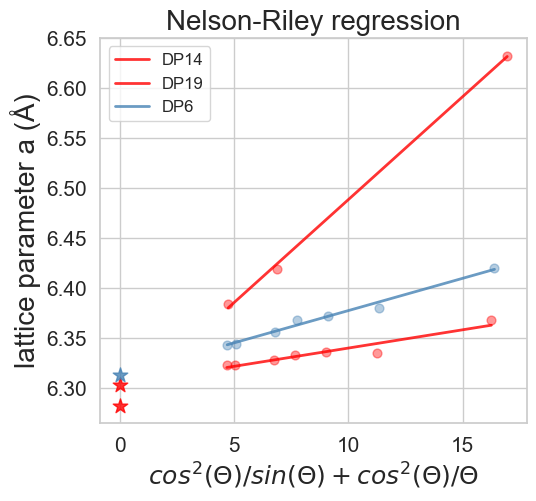

In [312]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black','green','orange','grey']
col_ind = 0
nrON = pd.DataFrame()
for samp in result_ON['Sample'].unique():   #)
    sample = result_ON[result_ON['Sample']==samp]
    if sample['Variation'].iloc[0]=='Mod':
        c = nelson_riley(sample,ax, col_array[1], 'a_raw', 'pos', alp=0.8, lab=samp)
    if sample['Variation'].iloc[0]=='Ref':
        c = nelson_riley(sample,ax, col_array[0], 'a_raw', 'pos', alp=0.8, lab=samp)
    #col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nrON = pd.concat([nrON, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=12)  
print(nrON)

In [ ]:
#Getting a certain scannumber

condi_longON = list(filter(lambda asset: '27' in asset.file, xrd_assets))
df_longON = pd.DataFrame()
index = 0
for ass in condi_longON:
    file = ass.file
    var = ass.metadata['var']
    samp = ass.metadata['name']
    two_theta, y, start_time, end_time = readXRDML(file)
    start = pd.to_datetime(start_time)
    end = pd.to_datetime(end_time)
    center, amplitude, stddev, peak_count = fit_XRD(two_theta, y, low_Xthres=25.8, high_Xthres=27.5, maxpeaks=5, y_thres=400, Fitplot=False)
    d = braggs(center[0])
    d_values.append(d)
    a = (a_value(d, 1, 1, 0))
    a_values.append(a)
    new_input = {
        'File':file,
        'FTO110_pos': center[0], 
        'Sample': samp,
        'Variation': var,
        'light':'dark',
        'temperature':'RT', 
        'd_value_fto110': d,
        'a_value_fto110':a, 
        'x_array': two_theta, 
        'y_array':y,
        'rel_a':1
    }
    index+=1
    new_row = pd.DataFrame([new_input], index=[index])
    df_longON = pd.concat([df_longON, new_row], ignore_index=True)
print(df_longON['x_array'].values)
print(df_longON['Sample'].unique())

[array([ 4.98377157,  5.01331471,  5.04285784, ..., 44.92609155,
        44.95563468, 44.98517782])
 array([19.01357157, 19.04311471, 19.07265784, 19.10220098, 19.13174411,
        19.16128725, 19.19083039, 19.22037352, 19.24991666, 19.27945979,
        19.30900293, 19.33854607, 19.3680892 , 19.39763234, 19.42717548,
        19.45671861, 19.48626175, 19.51580488, 19.54534802, 19.57489116,
        19.60443429, 19.63397743, 19.66352056, 19.6930637 , 19.72260684,
        19.75214997, 19.78169311, 19.81123624, 19.84077938, 19.87032252,
        19.89986565, 19.92940879, 19.95895192, 19.98849506, 20.0180382 ,
        20.04758133, 20.07712447, 20.1066676 , 20.13621074, 20.16575388,
        20.19529701, 20.22484015, 20.25438329, 20.28392642, 20.31346956,
        20.34301269, 20.37255583, 20.40209897, 20.4316421 , 20.46118524,
        20.49072837, 20.52027151, 20.54981465, 20.57935778, 20.60890092,
        20.63844405, 20.66798719, 20.69753033, 20.72707346, 20.7566166 ,
        20.78615973, 20.

In [317]:
#Defining the parameters of the experiment: Variation and what peaks are expected in what range of the scans.
variations = ['Ref','Mod']
max_num_peaks_per_sample = 19
peak_names = ['delta', 'i2Pb','p(001)', 'p(011)', 'unknown','p(111)', 'FTO(110)', 'p(002)', 'FTO2', 'p(012)', '(211)', 'defect', 'FTO3', 'Au', 'Au2', 'p(022)', 'p(003)', '(222)', 'FTO4', 'FTO5', '004']
peak_ranges = [[11.5,11.8],[12,12,9], [13,15], [19,20], [21,23], [24,25], [26,27],[28,29],[30,31],[31,32],[33,34],[34,36],[37,37.8], [37.8,39], [39,40], [40,41],[42,43], [43,45], [48,50.5], [50.5,52], [52,55],[55,60]]

df_list = [df_longON[df_longON['Sample']!='DP8']]
df_ranges = [[6, 44]]
maxpeaks = [19]

#Creating a dataframe and fitting the data
result_longON = pd.DataFrame()   #columns=['Sample', 'Variation', 'Peak', 'pos', 'amplitude', 'stdvG', 'd_value','a_rel', 'rel_a']
i = 0 
ythres=200
while i < len(df_list):
    new_result_df = framefit(df_list[i], peak_names, peak_ranges, df_ranges[i][0], df_ranges[i][1], maxpeaks[i], ref_ftoAvalue, ythres, pl=False)
    result_longON = pd.concat([result_longON, new_result_df])
    i+=1
print(result_longON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP21       Mod    p(011)  19.623152   711.184896  0.254584  4.524050   
1    DP21       Mod    p(111)  24.146908   385.200976  0.509406  3.685775   
2    DP21       Mod  FTO(110)  26.240295  1113.526875  0.508082  3.396291   
3    DP21       Mod   Unknown  27.988331   374.706173  0.301928  3.188021   
4    DP21       Mod    p(012)  31.440271  1130.443283  0.236441  2.845429   
5    DP21       Mod     (211)  33.445498   478.773078  0.212296  2.679276   
6    DP21       Mod    defect  34.568332   255.947531  0.221766  2.594778   
7    DP21       Mod      FTO3  37.507573  1326.258442  0.309866  2.397923   
8    DP21       Mod    p(022)  40.188933  1087.203279  0.304473  2.243907   
9    DP21       Mod    p(003)  42.758468   423.490803  0.225146  2.114825   
0     DP1       Ref    p(001)  13.902206   446.876540  0.235965  6.370209   
1     DP1       Ref    p(011)  19.792018  1126.061294  0.212603  4.485831   

In [320]:
#Calculating and adjusting a-values

a_values_raw = []
a_aligned = []
i = 0
while i < result_longON.index.size: 
    d = result_longON['d_value'].iloc[i]
    peak = result_longON['Peak'].iloc[i]
    rel_a  = result_longON['rel_a'].iloc[i]  #the correction in the intial calculation
    #a_rel  = result_df['a_rel'].iloc[i]
    if peak == 'FTO(110)':
        a = a_value(d,1,1,0)
        if a/ref_ftoAvalue != rel_a: #Checking that the correction (extracted again) is the same as in the intial calculation
            print('division error')
        a_corr = a/rel_a
    elif peak.startswith('p('):
        h = float(peak[2])
        k =  float(peak[3])
        l = float(peak[4])
        a = a_value(d, h , k, l)
        a_corr = a/rel_a   #Correcting a with the relative lateral alignment
    else: 
        a = 'NA'
        a_corr = 'NA'
    a_values_raw.append(a)
    a_aligned.append(a_corr)
    i+=1
        
result_longON['a_raw'] = a_values_raw
result_longON['a_final'] = a_aligned
print(result_longON)

   Sample Variation      Peak        pos    amplitude     stdvG   d_value  \
0    DP21       Mod    p(011)  19.623152   711.184896  0.254584  4.524050   
1    DP21       Mod    p(111)  24.146908   385.200976  0.509406  3.685775   
2    DP21       Mod  FTO(110)  26.240295  1113.526875  0.508082  3.396291   
3    DP21       Mod   Unknown  27.988331   374.706173  0.301928  3.188021   
4    DP21       Mod    p(012)  31.440271  1130.443283  0.236441  2.845429   
5    DP21       Mod     (211)  33.445498   478.773078  0.212296  2.679276   
6    DP21       Mod    defect  34.568332   255.947531  0.221766  2.594778   
7    DP21       Mod      FTO3  37.507573  1326.258442  0.309866  2.397923   
8    DP21       Mod    p(022)  40.188933  1087.203279  0.304473  2.243907   
9    DP21       Mod    p(003)  42.758468   423.490803  0.225146  2.114825   
0     DP1       Ref    p(001)  13.902206   446.876540  0.235965  6.370209   
1     DP1       Ref    p(011)  19.792018  1126.061294  0.212603  4.485831   

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_6264\3468635048.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


Mod [6.305776508011934] 6.305776508011934
Ref [6.31017032515707] 6.31017032515707
Ref [6.290893322898955] 6.290893322898955
  Sample Variation  intercept
0   DP21       Mod   6.305777
0    DP1       Ref   6.310170
0   DP12       Ref   6.290893


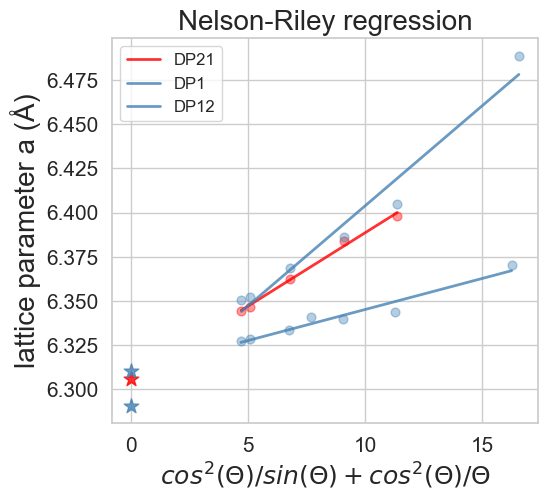

In [321]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black','green','orange','grey']
col_ind = 0
nrlongON = pd.DataFrame()
for samp in result_longON['Sample'].unique():   #)
    sample = result_longON[result_longON['Sample']==samp]
    if sample['Variation'].iloc[0]=='Mod':
        c = nelson_riley(sample,ax, col_array[1], 'a_raw', 'pos', alp=0.8, lab=samp)
    if sample['Variation'].iloc[0]=='Ref':
        c = nelson_riley(sample,ax, col_array[0], 'a_raw', 'pos', alp=0.8, lab=samp)
    #col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nrlongON = pd.concat([nrlongON, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=12)  
print(nrlongON)

<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_6264\2499059124.py:23: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


Mod [6.305776508011934] 6.305776508011934
Mod [6.270923685862283] 6.270923685862283
Ref [6.31017032515707] 6.31017032515707
Ref [6.285698510850395] 6.285698510850395
Ref [6.290893322898955] 6.290893322898955
Ref [6.2632506915674515] 6.2632506915674515
  Sample Variation  intercept
0   DP21       Ref   6.270924
0    DP1       Ref   6.285699
0   DP12       Ref   6.263251


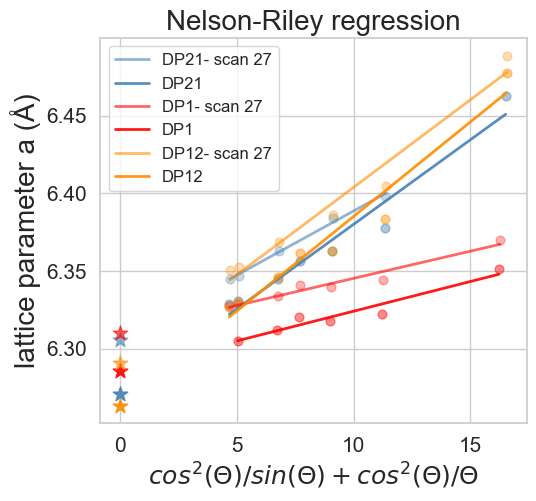

In [326]:
#Nelson-Riley figure, there are several options here, currently left as the included figure in the manuscript

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'darkorange', 'black','green','orange','grey', 'navy']
col_ind = 0
nrlong = pd.DataFrame()
for samp in result_longON['Sample'].unique():   #)
    long = result_longON[result_longON['Sample']==samp]
    init = result_df[result_df['Sample']==samp]
    if long['Variation'].iloc[0]=='Mod':
        c = nelson_riley(long,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.6, lab=samp+'- scan 27')
        c = nelson_riley(init,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.9, lab=samp)
    if long['Variation'].iloc[0]=='Ref':
        c = nelson_riley(long,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.6, lab=samp+'- scan 27')
        c = nelson_riley(init,ax, col_array[col_ind], 'a_raw', 'pos', alp=0.9, lab=samp)
    col_ind+=1
    nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
    nrlong = pd.concat([nrlong, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='upper left', fontsize=12)  
print(nrlong)

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\1180724946.py:20: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)


B4P5
Ref [6.31142428074104] 6.31142428074104
B4P18
Mod [6.30794504044467] 6.30794504044467
B4P3_scan10
Ref [6.340963213556863] 6.340963213556863
B4P11_scan10
Mod [6.334169675281775] 6.334169675281775


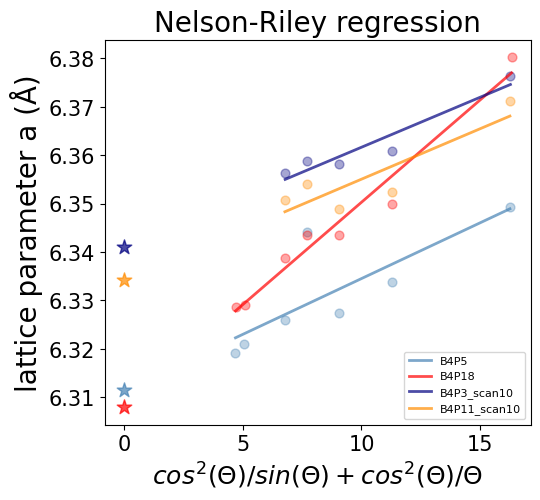

In [18]:
#Nelson-Riley figure with final (adjusted) a-values

fig = plt.figure(figsize=(5.5,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'navy', 'darkorange', 'black', 'chocolate', 'grey', 'magenta', 'crimson']
col_ind = 0
nr = pd.DataFrame()
for samp in df_xshift[df_xshift['iniType'].str.startswith('complet')]['Sample'].unique():   #)
    if samp.startswith('B4'):
        print(samp)
        sample = result_df[result_df['Sample']==samp]
        label= samp
        c = nelson_riley(sample,ax, col_array[col_ind], 'a_final', 'pos', 0.7, label)
        col_ind+=1
        nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
        nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=18)
#ax.set_ylim(6.295,6.310)
#ax.set_xlim(4.5,5.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Nelson-Riley regression', fontsize=20)
ax.legend(loc='lower right', fontsize=8)   

In [19]:
#This small calculation was used to identify outlier datapoints, leading to the elimination of (222), (004) and (112) from the analysis due to highly deviating values, probably because of low intensity of the peaks. 
the2 = 42
theta = the2/2
transform = math.cos(math.radians(theta))**2 / math.sin(math.radians(theta)) + math.cos(math.radians(theta))**2/math.radians(theta)
print(transform)

4.8100325786496345


Ref [6.327578450016769] 6.327578450016769
Mod [6.318581517905133] 6.318581517905133


<>:19: SyntaxWarning: invalid escape sequence '\T'
<>:19: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2885866371.py:19: SyntaxWarning: invalid escape sequence '\T'
  ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=20)


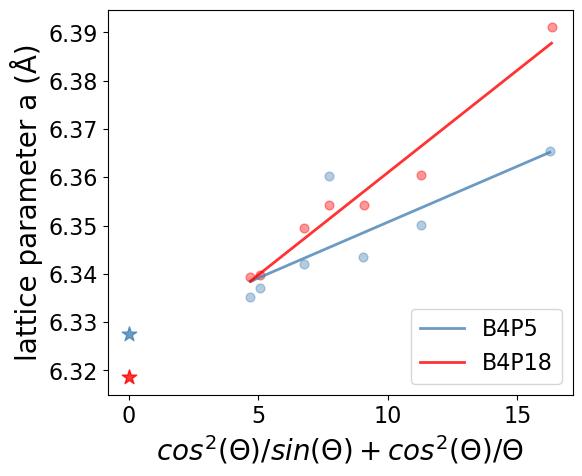

In [24]:
#Another plot variant with only the initial scans (RAW a value) of the batch used during time-resolved in-situ XRD

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
#ax.set_xlim(0,15)
#ax.set_ylim(6.31, 6.42)
col_array = ['steelblue', 'red', 'blue', 'purple']
col_ind = 0
nr = pd.DataFrame()
for samp in df_xshift[df_xshift['iniType'].str.startswith('complet')]['Sample'].unique():   #)
    if samp.startswith('B4'):
        if samp.endswith('scan10') == 0:
            sample = result_df[result_df['Sample']==samp]
            c = nelson_riley(sample,ax, col_array[col_ind], 'a_raw', 'pos', 0.8, samp)
            col_ind+=1
            nr_new = pd.DataFrame({'Sample':samp, 'Variation': sample['Variation'].iloc[0], 'intercept':c})
            nr = pd.concat([nr, nr_new])
ax.set_ylabel('lattice parameter a (Å)', fontsize=20)
ax.set_xlabel('$cos^2(\Theta) / sin(\Theta) + cos^2(\Theta)/\Theta$', fontsize=20)
#ax.set_ylim(6.315,6.365)
#ax.set_xlim(-0.5,12.5)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title('Nelson-Riley regression', fontsize=28)
ax.legend(loc='lower right', fontsize=16)  

In [25]:
#Export of the fitted data and Nelson Riley fitting of the intercept (realistic a value)
result_df.to_excel('MergeAlignCheck.xlsx')
nr.to_excel('Nelson_Riley_check.xlsx')
print(result_df)
print(nr)

          Sample Variation      Peak        pos    amplitude     stdvG  \
0           B4P3       Ref    p(111)  24.304752  1059.305059  0.159459   
1           B4P3       Ref  FTO(110)  26.418181  1176.217201  0.246292   
2           B4P3       Ref    p(002)  28.132913  2454.436297  0.210443   
3           B4P3       Ref    p(012)  31.552430  1391.326877  0.184897   
0          B4P11       Mod    p(111)  24.329046   613.702914  0.187082   
..           ...       ...       ...        ...          ...       ...   
5   B4P11_scan10       Mod  FTO(110)  26.428932  1153.163252  0.228686   
6   B4P11_scan10       Mod    p(002)  28.113381  2391.971368  0.209420   
7   B4P11_scan10       Mod    p(012)  31.529714  1134.973875  0.230490   
8   B4P11_scan10       Mod     (211)  33.617107   550.568650  0.255875   
9   B4P11_scan10       Mod    defect  34.625895   162.412687  0.196491   

     d_value     rel_a     a_raw   a_final  
0   3.662195  0.999478  6.343107  6.346421  
1   3.373825  0.99947

Text(0, 0.5, '2theta angle Pseudo Voigt fitting, \n perovskite (012) peak')

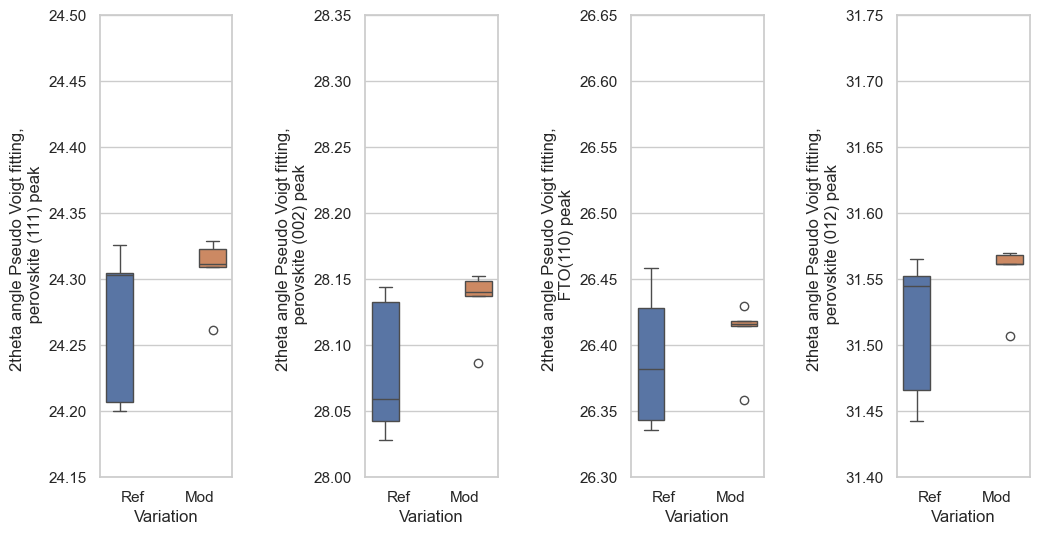

In [26]:
#A plot of the 2theta value

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax1, ax2, ax3, ax4 = axes.flatten()
i = 0

#B_df = result_df[result_df['Sample'].str.startswith('H')==0]
main_df = result_df[result_df['Sample'].str.startswith('F')==0]
ini_df = main_df[main_df['Sample'].str.endswith('scan10')==0]
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(111)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(002)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'FTO(110)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(012)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax4)


'''sns.boxplot(data=result_df[result_df['Peak'] == 'p(111)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(002)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=result_df[result_df['Peak'] == 'FTO(110)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(012)'], x='Variation', y='pos', hue = 'Variation', dodge='True', ax=ax4)'''

ax1.set_ylim(24.15,24.50)
ax2.set_ylim(28.00,28.35)
ax3.set_ylim(26.30,26.65)
ax4.set_ylim(31.40,31.75)
ax1.set_ylabel('2theta angle Pseudo Voigt fitting, \n perovskite (111) peak')
ax2.set_ylabel('2theta angle Pseudo Voigt fitting, \n perovskite (002) peak')
ax3.set_ylabel('2theta angle Pseudo Voigt fitting, \n FTO(110) peak')
ax4.set_ylabel('2theta angle Pseudo Voigt fitting, \n perovskite (012) peak')


Text(0, 0.5, 'a value (Angstrom) \n p(012) peak')

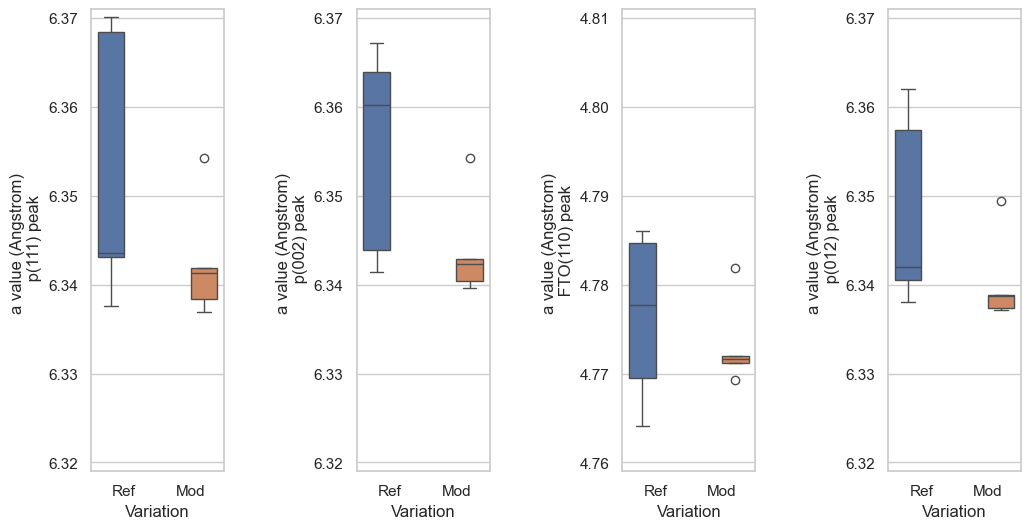

In [27]:
#A plot of the raw a-value value

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax1, ax2, ax3, ax4 = axes.flatten()
i = 0
'''sns.boxplot(data=result_df[result_df['Peak'] == 'p(111)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(002)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=result_df[result_df['Peak'] == 'FTO(110)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(012)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax4)'''

B_df = result_df[result_df['Sample'].str.startswith('H')==0]
main_df = B_df[B_df['Sample'].str.startswith('F')==0]
ini_df = main_df[main_df['Sample'].str.endswith('scan10')==0]
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(111)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(002)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'FTO(110)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(012)'], x='Variation', y='a_raw', hue = 'Variation', dodge='True', ax=ax4)

ax1.set_ylim(6.319,6.371)
ax2.set_ylim(6.319,6.371)
ax3.set_ylim(4.759,4.811)
ax4.set_ylim(6.319,6.371)
ax1.set_ylabel('a value (Angstrom) \n p(111) peak')
ax2.set_ylabel('a value (Angstrom) \n p(002) peak')
ax3.set_ylabel('a value (Angstrom) \n FTO(110) peak ')
ax4.set_ylabel('a value (Angstrom) \n p(012) peak')


Text(0, 0.5, 'a value (Angstrom) \n (012) peak')

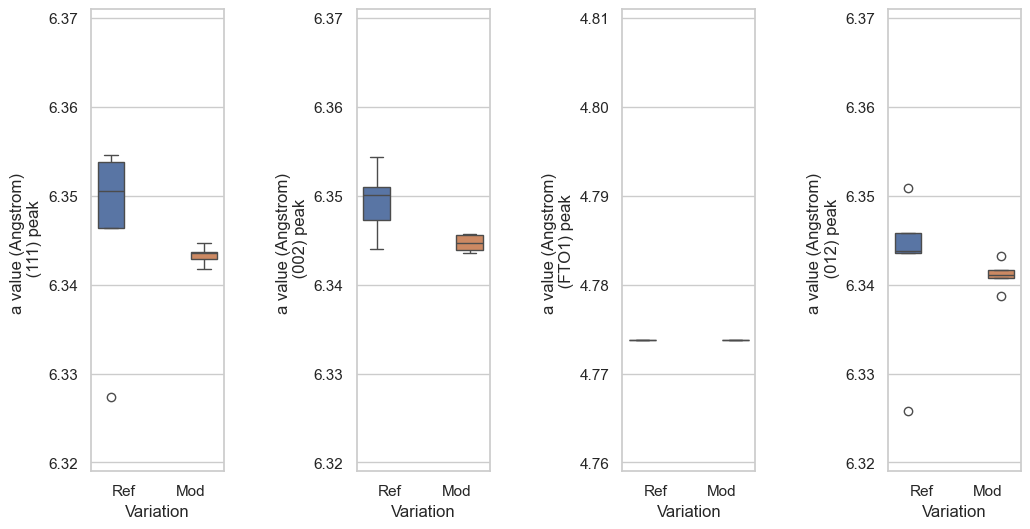

In [28]:
#A plot of the aligned a-value value

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
ax1, ax2, ax3, ax4 = axes.flatten()
i = 0

B_df = result_df[result_df['Sample'].str.startswith('H')==0]
main_df = B_df[B_df['Sample'].str.startswith('F')==0]
ini_df = main_df[main_df['Sample'].str.endswith('scan10')==0]
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(111)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(002)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'FTO(110)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=ini_df[ini_df['Peak'] == 'p(012)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax4)

'''sns.boxplot(data=result_df[result_df['Peak'] == 'p(111)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax1)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(002)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax2)
sns.boxplot(data=result_df[result_df['Peak'] == 'FTO(110)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax3)
sns.boxplot(data=result_df[result_df['Peak'] == 'p(012)'], x='Variation', y='a_final', hue = 'Variation', dodge='True', ax=ax4)'''

ax1.set_ylim(6.319,6.371)
ax2.set_ylim(6.319,6.371)
ax3.set_ylim(4.759,4.811)
ax4.set_ylim(6.319,6.371)
ax1.set_ylabel('a value (Angstrom) \n (111) peak')
ax2.set_ylabel('a value (Angstrom) \n (002) peak')
ax3.set_ylabel('a value (Angstrom) \n (FTO1) peak ')
ax4.set_ylabel('a value (Angstrom) \n (012) peak')


<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2423796052.py:9: SyntaxWarning: invalid escape sequence '\T'
  g.set_axis_labels('','2$\Theta$', fontsize=18)
c:\Users\fbaumann\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\fbaumann\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


IndexError: tuple index out of range

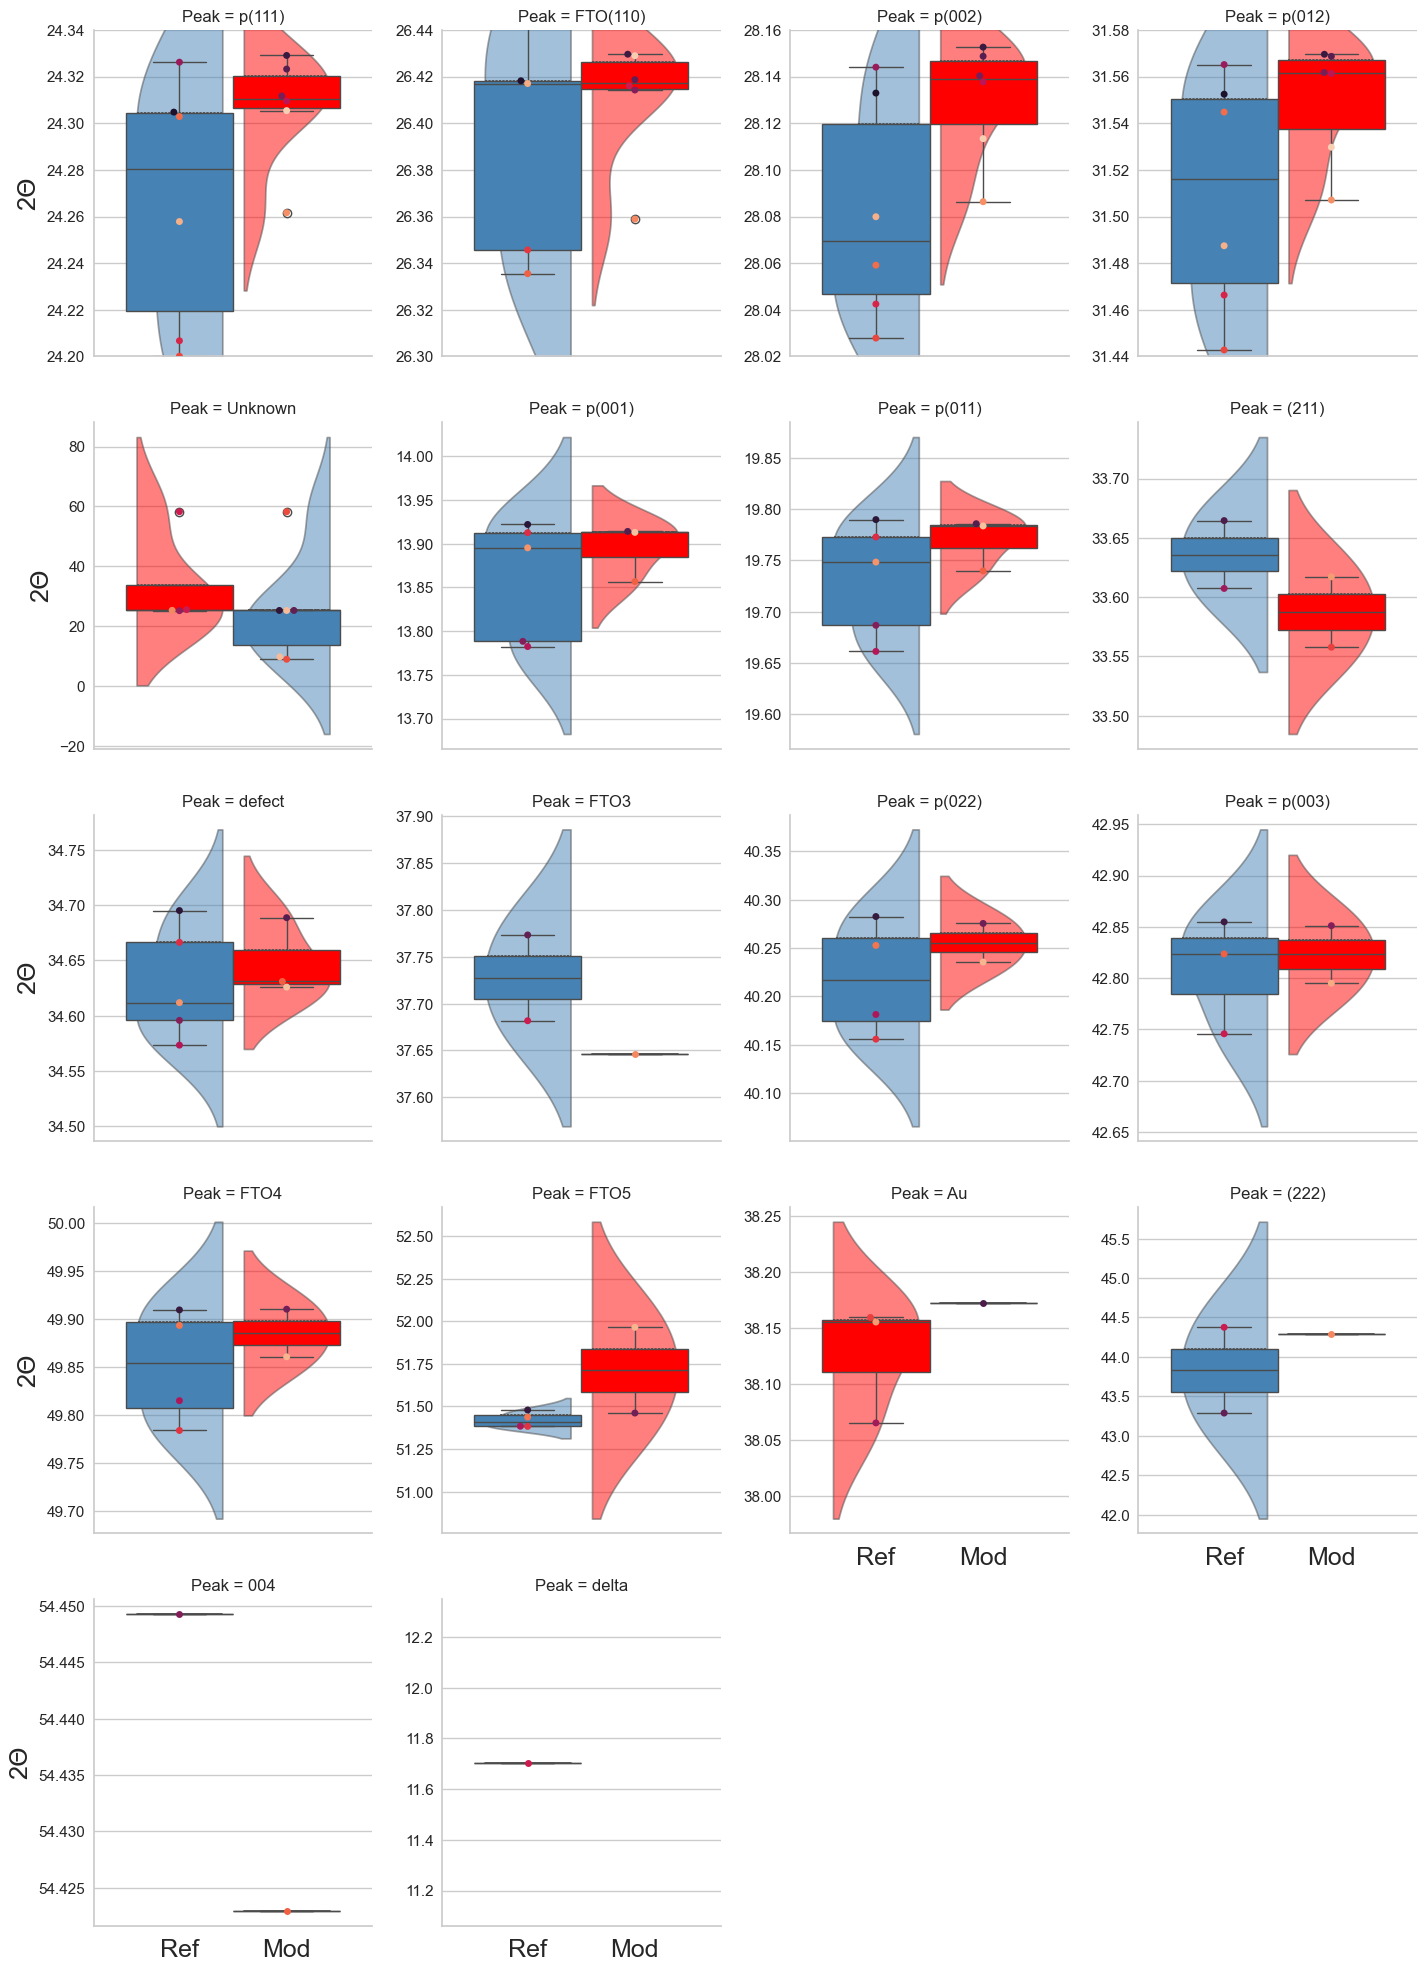

In [ ]:
#Statistics on peak data

x_tick = result_df['Variation'].unique()
sns.set(style="whitegrid")
g = sns.FacetGrid(result_df, col="Peak", col_wrap=4, aspect=0.9, height=4, sharey=False)
# Boxplot with hue on each facet
g.map_dataframe(sns.swarmplot, x='Variation', y='pos', hue='Sample', dodge=False, palette='rocket')
violin = g.map_dataframe(sns.violinplot, x='Variation', y='pos', hue='Variation', split=True, inner='quartile', palette=['steelblue', 'red'], saturation=1,  alpha=0.5)
g.map_dataframe(sns.boxplot, x = 'Variation', y= 'pos', hue='Variation', palette=['steelblue', 'red'], saturation=1, width=1)
#legd = g.add_legend(title='Peak center ( 2$\dot{\Theta}$, Gaussian) after alignment to FTO1')
g.set_axis_labels('','2$\Theta$', fontsize=18)
g.set_xticklabels(x_tick, fontsize=18)
g.tick_params('y', size=14, pad=-8)
matplotlib.rcParams.update({'figure.autolayout': False})

tick_lims = ([24.20, 24.34],[26.30, 26.44], [28.02, 28.16], [31.44, 31.58])
for i, ax in enumerate(g.axes.flat):
    ax.set_ylim(tick_lims[i])
    ax.set_xlim([-0.8, len(result_df['Variation'].unique())-0.2])
    tick_array = np.linspace(tick_lims[i][0], tick_lims[i][1], 7)
    #ax.set_yticklabels([f'{tick:.2f}' for tick in tick_array], fontsize=16)

for ax in g.axes.flat:
    for artist in ax.collections:
        artist.set_alpha(0.5)  # Set transparency here
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

In [32]:
#Reading in the initial scans to plot the full spectra
initial = pd.DataFrame(columns=['Variation', 'X', 'Y', 'Y_BC'])
print(df_complet)
for row in df_complet.index:
    #shift = df_complet['rel_a'][row]
    x_array = [float(column) for column in df_complet.columns[7:]]
    y_array = [df_complet[column][row] for column in df_complet.columns [7:]]
    x_carray = np.array(x_array)
    y_carray = np.array(y_array)
    estimated_background = airpls(y_carray)
    y_bc_carray = y_carray-estimated_background
    if df_complet['FileName'][row].startswith('2'):
        var = df_complet['Variation'][row]
        for i,x in enumerate(x_carray): 
            new_instance = {
            'Variation': var, 
            'X': x, 
            'Y': y_carray[i],
            'Y_BC': y_bc_carray[i]
            }
            initial.loc[len(initial.index)] = new_instance  
    #amplitude, mean, cov = fit_to_peak(x_array[600:670], y_bc_carray[600:670], False)
    #centers_fto1.append(mean)
    #amplitudes.append(amplitude)
print(initial)
        

  Variation Voltage    Sample                         FileName  8.01877  \
0       Ref       0   B1105P7            1105-01_S7_0V_complet      347   
1       Mod    none  B1105P11         1105-01_S11_H3PP_complet      331   
2       Ref       0   B1205P5            1205-01_S5_0V_complet      355   
3       Ref       0   B1205P7            1205-01_S7_0V_complet      442   
4       Ref       0   B1205P7    1205-02_S7_0V_visible_complet      402   
5       Ref    none      B4P5  2006-01_Sample5_visible_complet      623   
6       Mod    none     B4P18         2106-01_Sample18_complet      582   

   8.04831  8.07786  8.1074  8.13694  8.16649  ...  59.71926  59.7488  \
0      377      307     303      336      344  ...        74       84   
1      371      331     348      366      357  ...        67       75   
2      340      374     361      356      360  ...        71       72   
3      390      430     396      407      375  ...        77       76   
4      415      365     398      3

In [33]:
#Reading in the "after" scans at scan 10 (13 hours into the experiment) to plot the full spectra
x_ref = [float(column) for column in df_after_complet.columns[4:]]
y_ref = [df_after_complet[column].iloc[0] for column in df_after_complet.columns[4:]]
y_aref = np.array(y_ref)
x_aref = np.array(x_ref)
y_bc_aref = y_ref - airpls(y_aref)
#shift_mod = df_partial['ShiftP'].iloc[1]
x_mod = [float(column) for column in df_after_complet.columns[4:]]
y_mod = [df_after_complet[column].iloc[1] for column in df_after_complet.columns[4:]]
y_amod = np.array(y_mod)
x_amod = np.array(x_mod)
y_bc_amod = y_mod - airpls(y_amod)

<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:25: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:25: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2983225834.py:4: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('2$\Theta$', size=12, labelpad=-2)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2983225834.py:25: SyntaxWarning: invalid escape sequence '\T'
  ax2.set_xlabel('2$\Theta$',size=12, labelpad=-2)


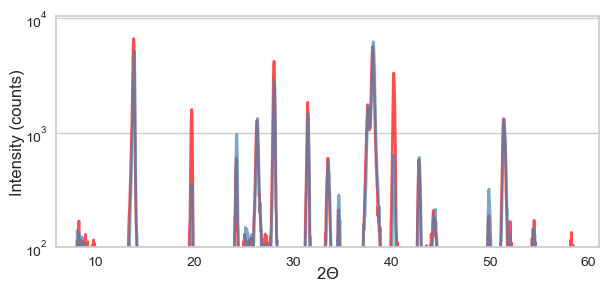

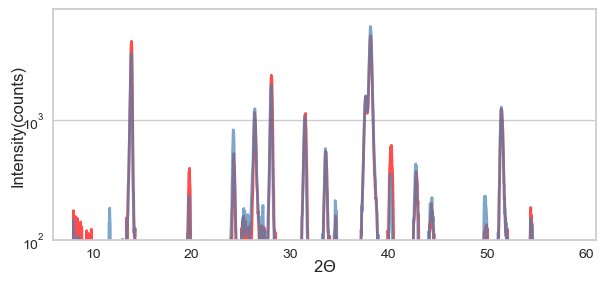

In [34]:
#Before plot and after plot
fig1 = plt.figure(figsize=(7,3))
ax1 = fig1.gca()
ax1.set_xlabel('2$\Theta$', size=12, labelpad=-2)
ax1.set_ylabel('Intensity (counts)', size=12, labelpad=0)
ax1.set_xlim(6,61)
ax1.set_ylim(100,10400)
ax1.set_yscale('log')
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='both', labelsize=10, pad=0)
ax1.grid(axis='y',visible=True)
ax1.grid(axis='x',visible=False)
#ax1.tick_params('both', size=6)

mod_initial = initial[initial['Variation']=='Mod']
y_mod_carray = [y for y in mod_initial['Y_BC']]
ax1.plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.7, lw=2)  #[600:670]          
ref_initial = initial[initial['Variation']=='Ref']
y_ref_carray = [y for y in ref_initial['Y_BC']]
ax1.plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.7, lw=2)  #[600:670]

     
fig2 = plt.figure(figsize=(7,3))
ax2 = fig2.gca()
ax2.set_xlabel('2$\Theta$',size=12, labelpad=-2)
ax2.set_ylabel('Intensity(counts)', size=12, labelpad=-2)
ax2.tick_params(axis='both', labelsize=10, pad=0)
ax2.plot(x_amod,y_bc_amod, color='red', alpha=0.7, lw=2)
ax2.plot(x_aref,y_bc_aref, color='steelblue', alpha=0.7, lw=2)
ax2.set_xlim(6,61)
ax2.set_ylim(100,8400)
ax2.set_yscale('log')
ax2.grid(axis='y',visible=True)
ax2.grid(axis='x',visible=False)
#shift_ref = df_partial['ShiftP'].iloc[0]


<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\4131881971.py:5: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\4131881971.py:29: SyntaxWarning: invalid escape sequence '\T'
  fig.suptitle('2$\Theta$', size=22, y=0.03)


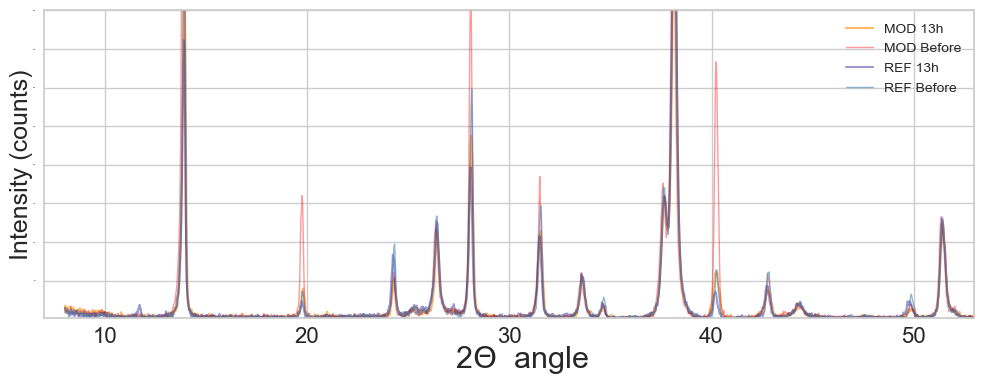

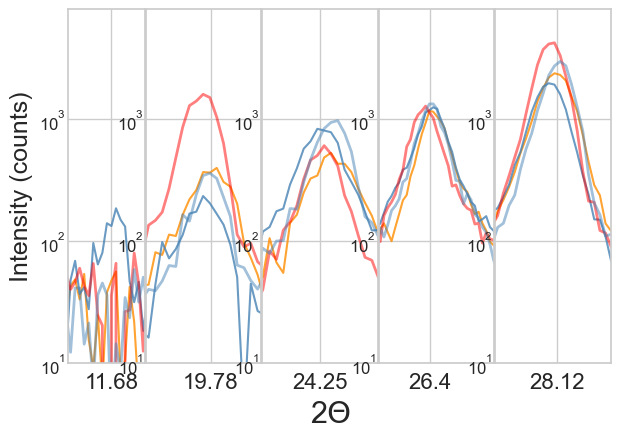

In [35]:
#Before/After for each variation

fig1 = plt.figure(figsize=(12,4))
ax1 = fig1.gca()
ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
ax1.set_ylabel('Intensity (counts)', size=18, labelpad=0)
ax1.set_xlim(7,53)
ax1.set_ylim(10,4000)
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='x', labelsize=16, pad=0)
ax1.tick_params(axis='y', labelsize=0, pad=0)
ax1.set_xticks([10,20,30,40,50])
ax1.grid(axis='y',visible=True)

ax1.plot(x_amod,y_bc_amod, color='darkorange', alpha=0.6, lw=1.5, label='MOD 13h')
mod_initial = initial[initial['Variation']=='Mod']
y_mod_carray = [y for y in mod_initial['Y_BC']]
ax1.plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.4, lw=1, label='MOD Before')  #[600:670]

ax1.plot(x_ref,y_bc_aref, color='navy', alpha=0.4, lw=1.5, label='REF 13h')
ref_initial = initial[initial['Variation']=='Ref']
y_ref_carray = [y for y in ref_initial['Y_BC']]
ax1.plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.6, lw=1, label='REF Before')  #[600:670]
ax1.legend(loc='upper right', frameon=False, fontsize=10)



fig, axs = plt.subplots(1, 5, figsize=(7, 4.6), gridspec_kw={'width_ratios': [2, 3,3,3,3]})
fig.suptitle('2$\Theta$', size=22, y=0.03)

axs[3].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[3].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[3].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[3].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[3].set_xlim(26.0,26.9)
axs[3].set_xticks([26.4])

axs[4].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[4].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[4].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[4].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[4].set_xlim(27.8,28.4)
axs[4].set_xticks([28.12])


axs[1].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[1].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[1].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[1].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[1].set_xlim(19.5, 20.0)  # Set the x-axis limits for the first interval
axs[1].set_xticks([19.78])

axs[2].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[2].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[2].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[2].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
#axs[2].set_xlim(39.5,41.5)
#axs[2].set_xticks([40.3])
axs[2].set_xlim(24.0,24.5)
axs[2].set_xticks([24.25])



axs[0].set_ylabel('Intensity (counts)', size=18)
axs[0].plot(x_amod,y_bc_amod, color='darkorange', alpha=0.8, lw=1.5)
axs[0].plot(x_aref,y_bc_aref, color='steelblue', alpha=0.8, lw=1.5)
axs[0].plot(mod_initial['X'], y_mod_carray, color = 'red', alpha= 0.5, lw=2)
axs[0].plot(ref_initial['X'], y_ref_carray, color = 'steelblue', alpha= 0.5, lw=2) 
axs[0].set_xlim(11.4,11.9)
axs[0].set_xticks([11.68])


for ax in axs:
    ax.grid(axis='both', visible=True)
    ax.tick_params(axis='y', length=2, labelsize=12, pad=0)
    ax.tick_params(axis='x', pad=0, labelsize=16)
    ax.set_yticks([0, 1500, 3000, 4500, 6000, 7500])
    ax.set_yscale('log')
    ax.set_ylim(10,8000)

# Add a gap in the x-axis between the two subplots
plt.subplots_adjust(wspace=0.01)

# Show the plot
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:33: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:33: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2684378111.py:5: SyntaxWarning: invalid escape sequence '\T'
  ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_7216\2684378111.py:33: SyntaxWarning: invalid escape sequence '\T'
  fig.suptitle('2$\Theta$', size=22, y=0.03)


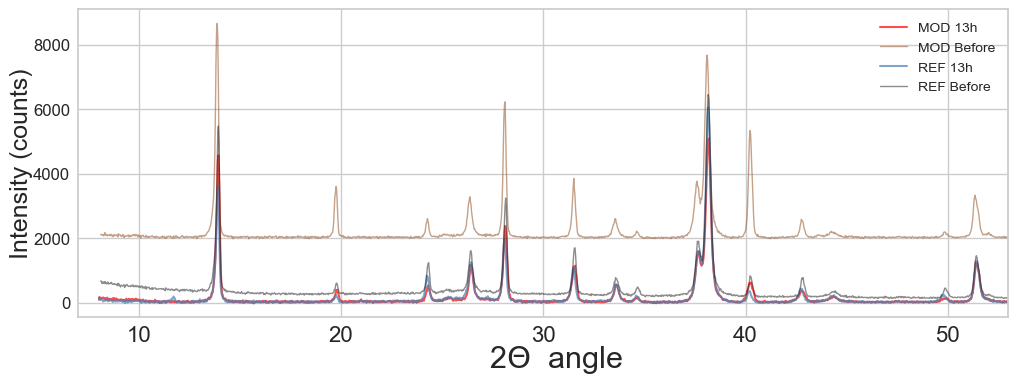

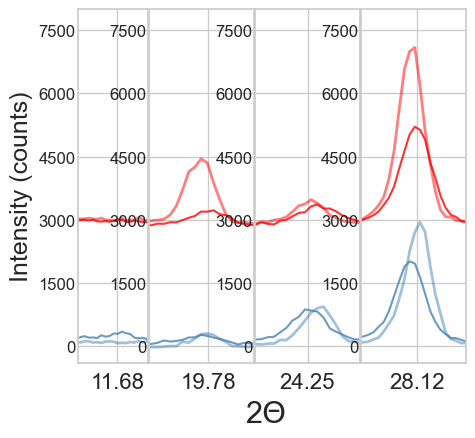

In [ ]:
#Before/After for each variation zoomed in

fig1 = plt.figure(figsize=(12,4))
ax1 = fig1.gca()
ax1.set_xlabel('   2$\Theta$  angle', size=22, labelpad=-2)
ax1.set_ylabel('Intensity (counts)', size=18, labelpad=0)
ax1.set_xlim(7,53)
#ax1.set_ylim(-1000,14400)
#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.tick_params(axis='x', labelsize=16, pad=0)
ax1.tick_params(axis='y', labelsize=12, pad=0)
ax1.set_xticks([10,20,30,40,50])
ax1.grid(axis='y',visible=True)

ax1.plot(x_amod,y_bc_amod, color='red', alpha=0.7, lw=1.5, label='MOD 13h')
mod_initial = initial[initial['Variation']=='Mod']
y_mod_carray = [y+2000 for y in mod_initial['Y_BC']]
ax1.plot(mod_initial['X'], y_mod_carray, color = 'saddlebrown', alpha= 0.5, lw=1, label='MOD Before')  #[600:670]

x_ref = [float(column) for column in df_after_complet.columns[4:]]
#y_ref = [df_after_complet[column].iloc[0]+1800 for column in df_after_complet.columns[4:]]
ax1.plot(x_aref,y_bc_aref, color='steelblue', alpha=0.7, lw=1.5, label='REF 13h')
ref_initial = initial[initial['Variation']=='Ref']
y_ref_carray = [y for y in ref_initial['Y']]
ax1.plot(ref_initial['X'], y_ref_carray, color = 'k', alpha= 0.5, lw=1, label='REF Before')  #[600:670]
ax1.legend(loc='upper right', frameon=False, fontsize=10)



fig, axs = plt.subplots(1, 4, figsize=(5, 4.6), gridspec_kw={'width_ratios': [2, 3,3,3]})


fig.suptitle('2$\Theta$', size=22, y=0.03)
#ax3.set_ylabel('Intensity (counts)', size=12)

'''#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax3.tick_params(axis='both', labelsize=10, pad=-2)
ax3.set_xticks([27.92, 28.12, 28.32])
ax3.set_yticks([0, 1500, 3000, 4500, 6000])
ax3.grid(axis='y',visible=True)'''
y_modin_002 = [y+2600 for y in mod_initial['Y']]
y_mod_002 = [df_after_complet[column].iloc[1]+2600 for column in df_after_complet.columns[4:]]
y_ref_002 = [df_after_complet[column].iloc[0]-200 for column in df_after_complet.columns[4:]]
#ax3.plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)  #[600:670]   
y_refin_002 = [y-300 for y in ref_initial['Y']]
#ax3.plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2)  #[600:670]



axs[3].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[3].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[3].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[3].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
axs[3].set_xlim(27.8,28.4)
axs[3].set_ylim(-400,8000)
axs[3].set_xticks([28.12])


axs[1].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[1].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[1].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[1].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
axs[1].set_xlim(19.5, 20.0)  # Set the x-axis limits for the first interval
axs[1].set_xticks([19.78])
axs[1].set_ylim(-400,8000)

axs[2].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[2].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[2].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[2].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
#axs[2].set_xlim(39.5,41.5)
#axs[2].set_xticks([40.3])
axs[2].set_xlim(24.0,24.5)
axs[2].set_xticks([24.25])
axs[2].set_ylim(-400,8000)


axs[0].set_ylabel('Intensity (counts)', size=18)
axs[0].plot(x_mod,y_mod_002, color='red', alpha=0.8, lw=1.5)
axs[0].plot(x_ref,y_ref_002, color='steelblue', alpha=0.8, lw=1.5)
axs[0].plot(mod_initial['X'], y_modin_002, color = 'red', alpha= 0.5, lw=2)
axs[0].plot(ref_initial['X'], y_refin_002, color = 'steelblue', alpha= 0.5, lw=2) 
axs[0].set_xlim(11.4,11.9)
axs[0].set_xticks([11.68])
axs[0].set_ylim(-400,8000)

for ax in axs:
    ax.grid(axis='both', visible=True)
    ax.tick_params(axis='y', length=2, labelsize=12, pad=0)
    ax.tick_params(axis='x', pad=0, labelsize=16)
    ax.set_yticks([0, 1500, 3000, 4500, 6000, 7500])

# Add a gap in the x-axis between the two subplots
plt.subplots_adjust(wspace=0.01)

# Show the plot
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fbaumann\AppData\Local\Temp\ipykernel_13760\319597765.py:2: SyntaxWarning: invalid escape sequence '\T'
  axs[1].set_xlabel('2$\Theta$', size=12)


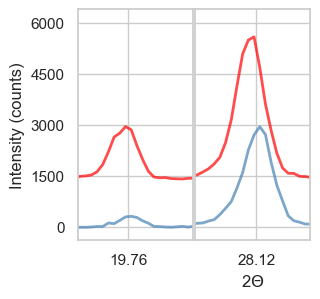

In [ ]:
#Zoom in of peaks, before and after

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3, 3))
axs[1].set_xlabel('2$\Theta$', size=12)
#ax3.set_ylabel('Intensity (counts)', size=12)

'''#ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax3.tick_params(axis='both', labelsize=10, pad=-2)
ax3.set_xticks([27.92, 28.12, 28.32])
ax3.set_yticks([0, 1500, 3000, 4500, 6000])
ax3.grid(axis='y',visible=True)'''
y_mod_002 = [y+1100 for y in mod_initial['Y']]
#ax3.plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)  #[600:670]   
y_ref_002 = [y-300 for y in ref_initial['Y']]
#ax3.plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2)  #[600:670]

axs[1].plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)
axs[1].plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2) 
axs[1].set_xlim(27.8,28.4)
axs[1].set_ylim(-400,6400)
axs[1].set_xticks([28.12])

axs[0].set_yticks([0, 1500, 3000, 4500, 6000])
axs[0].set_ylabel('Intensity (counts)', size=12)
axs[0].plot(mod_initial['X'], y_mod_002, color = 'red', alpha= 0.7, lw=2)
axs[0].plot(ref_initial['X'], y_ref_002, color = 'steelblue', alpha= 0.7, lw=2) 
axs[0].set_xlim(19.5, 20.1)  # Set the x-axis limits for the first interval
axs[0].set_xticks([19.76])

# Add a gap in the x-axis between the two subplots
plt.subplots_adjust(wspace=0.01)

# Show the plot
plt.show()